# Analysis

## Load Data

In [1]:
%load_ext autoreload
%autoreload 2
import json
import numpy as np
import pandas as pd

from pathlib import Path
from src.db_utils import get_schema_str
from src.database import SqliteDatabase
from src.spider_sparc_preprocess import (
    load_spider_sparc_data,
    process_all_tables, 
    load_samples_spider,
    load_samples_sparc,
    filter_samples_by_count_sparc,
    filter_samples_by_count_spider, 
    process_samples_sparc,
    process_samples_spider, 
    split_train_dev_test,
    save_samples_spider
)

proj_path = Path('.').resolve()

## Spider Dataset

In [2]:
# spider_path = proj_path / 'data' / 'spider'
# tables, train_data, dev_data = load_spider_sparc_data(spider_path, load_test=False)

# with (proj_path / 'data' / 'description.json').open() as f:
#     all_descriptions = json.load(f)
# spider_tables = process_all_tables(tables, descriptions=all_descriptions)

# # # --------------- split_in_domain ----------------
# # all_data = filter_samples_by_count_spider(train_data+dev_data, n=10)
# # # process samples -> {db_id: list of samples}
# # spider_samples = process_samples_spider(all_data, spider_tables, skip=[])
# # # change train/dev by sample
# # train_samples, dev_samples, test_samples = split_train_dev_test(spider_samples, train_ratio=0.8, dev_ratio=0.1)

# # ------------------ split_by_domain ----------------
# def values_flatten(x: dict[str, list]) -> list:
#     return [item for sublist in x.values() for item in sublist]

# train_samples = process_samples_spider(train_data, spider_tables, skip=[])
# train_samples = values_flatten(train_samples)

# dev_samples = process_samples_spider(dev_data, spider_tables, skip=[])
# dev_samples = values_flatten(dev_samples)
# # test_samples = process_samples_spider(test_data, spider_tables, skip=[])
# test_samples = []
# print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)} | Number of test: {len(test_samples)}')

# save_samples_spider(train_samples, proj_path / 'data' / 'spider_train.json')
# save_samples_spider(dev_samples, proj_path / 'data' / 'spider_dev.json')
# # save_samples_spider(test_samples, proj_path / 'data' / 'spider_test.json')

In [3]:
with (proj_path / 'data' / 'spider' / f'tables.json').open() as f:
    tables = json.load(f)

with (proj_path / 'data' / 'description.json').open() as f:
    all_descriptions = json.load(f)
spider_tables = process_all_tables(tables, descriptions=all_descriptions)

train_samples = load_samples_spider(proj_path / 'data' / 'spider_train.json')
dev_samples = load_samples_spider(proj_path / 'data' / 'spider_dev.json')
# test_samples = load_samples_spider(proj_path / 'data' / 'spider_test.json')
test_samples = []
print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)} | Number of test: {len(test_samples)}')

Number of train: 7000 | Number of dev: 1034 | Number of test: 0


## Test SQL generation

* gpt-4o-mini
* gemini

In [4]:
import os 
from src.spider_sparc_preprocess import DatabaseModel, SpiderSample
from dotenv import load_dotenv, find_dotenv
from collections import defaultdict
from tqdm import tqdm
from langchain_core.runnables import RunnableSequence
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

_ = load_dotenv(find_dotenv())

class Response(BaseModel):
    full_sql_query: str = Field(description='The full SQL query.')
    rationale: list[str] = Field(description='The step-by-step reasoning to generate the SQL query. Each step has ')

# class Response(BaseModel):
#     output: list[OutputFormat]

template = '''### TASK
You are tasked with generating a SQL query(in a SQLite Database) according to a user input request.
You should work in step-by-step reasoning before coming to the full SQL query.

You will be provided an input NL query.

### SCHEMA
You are working with the following schema in a SQLite Database:
{schema}

### FORMATTING
Your output should be of the following JSON format:
{{
    "rationale": "<list[str]: the step-by-step reasoning to generate the SQL query>",
    "full_sql_query": "<str: the full SQL query>"
}}

### OUTPUT
<INPUT QUERY>: {input_query}
<OUTPUT>: 
'''

prompt = PromptTemplate(
    template=template,
    input_variables=['schema', 'input_query']
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
)

model = model_openai.with_structured_output(Response)
chain = (prompt | model)

def predict_sql(samples: list[SpiderSample], spider_tables: dict[str, DatabaseModel], chain: RunnableSequence, k: int = 500, file_name: str = 'full_sql_output') -> list[dict]:
    all_full_sql = list()
    for i, data in tqdm(enumerate(samples), total=len(samples)):
        db_schema = get_schema_str(
            schema=spider_tables[data.db_id].db_schema, 
            foreign_keys=spider_tables[data.db_id].foreign_keys,
            col_explanation=spider_tables[data.db_id].col_explanation
        )
        input_data = {'schema': db_schema, 'input_query': data.final.question}
        output = chain.invoke(input=input_data)

        full_sql_output = {}
        full_sql_output['sample_id'] = data.sample_id
        full_sql_output['db_id'] = data.db_id
        full_sql_output['question'] = data.final.question
        full_sql_output['rationale'] = output.rationale
        full_sql_output['pred_sql'] = output.full_sql_query
        full_sql_output['gold_sql'] = data.final.sql
        full_sql_output['source_tables'] = data.final.source_tables
        all_full_sql.append(full_sql_output)

        if len(all_full_sql) == k:
            with open(proj_path / 'experiments' / f'{file_name}_{i//k}.jsonl', 'w') as f:
                for d in all_full_sql:
                    f.write(json.dumps(d) + '\n')
            all_full_sql = list()

    if len(all_full_sql) > 0:
        with open(proj_path / 'experiments' / f'{file_name}_{i//k}.jsonl', 'w') as f:
            for d in all_full_sql:
                f.write(json.dumps(d) + '\n')

In [5]:
# train_predictions = predict_sql(train_samples, spider_tables, chain, k=500, file_name='spider_train')
# dev_predictions = predict_sql(dev_samples, spider_tables, chain, k=500, file_name='spider_dev')
# test_predictions = predict_sql(test_samples, spider_tables, chain, k=500, file_name='spider_test')

In [6]:
def load_predictions(file_pattern: str) -> list[dict]:
    predictions = []
    for p in sorted((proj_path / 'experiments').glob(file_pattern), key=lambda x: int(x.stem.split('_')[-1])):
        with p.open() as f:
            for line in f:
                predictions.append(json.loads(line))
    return predictions

train_predictions = load_predictions('spider_train_*')
dev_predictions = load_predictions('spider_dev_*')

In [7]:
## database execution evaluation
from src.eval import result_eq, check_if_exists_orderby

def get_output_results(predictions: list[dict], spider_tables: dict[str, DatabaseModel]) -> tuple[list[dict], dict[str, list]]:
    output_results = []
    error_infos = {
        'pred_exec': [],
        'gold_exec': [],
        'python_script': [],
        'result': []
    }

    iterator = tqdm(predictions, total=len(predictions))
    for data in iterator:
        iterator.set_description(f'pred_exec: {len(error_infos["pred_exec"])} | gold_exec: {len(error_infos["gold_exec"])} | python_script: {len(error_infos["python_script"])} | result: {len(error_infos["result"])}')
        sample_id = data['sample_id']
        db_id = data['db_id']
        table = spider_tables[db_id]
        database = SqliteDatabase(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)
        pred_sql = data['pred_sql'] # sqlglot.parse_one(, read='sqlite').sql()
        gold_sql = data['gold_sql']
        
        error_info = ''
        try:
            pred_result = database.execute(pred_sql, rt_pandas=False)
        except Exception as e:
            pred_result = []
            error_infos['pred_exec'].append(sample_id)
            error_info = 'Predction Execution Error:' + str(e)
            score = 0
        try:
            gold_result = database.execute(gold_sql, rt_pandas=False)
        except Exception as e:
            error_infos['gold_exec'].append(sample_id)
            error_info = 'Gold Execution Error:' + str(e)

        if 'Gold Execution Error' in error_info:
            continue
        elif 'Predction Execution Error' in error_info:
            output_results.append(
                {
                    'sample_id': sample_id, 
                    'db_id': db_id,
                    'score': score,
                    'gold_sql': gold_sql,
                    'pred_sql': pred_sql,
                    'source_tables': data['source_tables'],
                    'error_info': error_info
                }
            )
            continue
        else:
            exists_orderby = check_if_exists_orderby(gold_sql)
            
            try:
                score = int(result_eq(pred_result, gold_result, order_matters=exists_orderby))
            except Exception as e:
                print(f"An error occurred: {e}")
                score = 0
                error_info = 'Python Script Error:' + str(e)
                error_infos['python_script'].append(sample_id)

            if score == 0 and error_info == '':
                error_info = 'Result not equal'
                error_infos['result'].append(sample_id)
            output_results.append(
                {
                    'sample_id': sample_id, 
                    'db_id': db_id,
                    'score': score,
                    'gold_sql': gold_sql,
                    'pred_sql': pred_sql,
                    'source_tables': data['source_tables'],
                    'error_info': error_info
                }
            )

    return output_results, error_infos

# train_output_results, train_errors = get_output_results(train_predictions, spider_tables)
# dev_output_results, dev_errors = get_output_results(dev_predictions, spider_tables)

# eval_path = proj_path / 'experiments' / 'evals'
# if not eval_path.exists():
#     eval_path.mkdir()

# with open(eval_path / 'spider_train_eval.json', 'w') as f:
#     json.dump(train_output_results, f)

# with open(eval_path / 'spider_train_errors.json', 'w') as f:
#     json.dump(train_errors, f)

# with open(eval_path / 'spider_dev_eval.json', 'w') as f:
#     json.dump(dev_output_results, f)

# with open(eval_path / 'spider_dev_errors.json', 'w') as f:
#     json.dump(dev_errors, f)

## Complexity of the SQL

```yaml
val: number(float)/string(str)/sql(dict)
col_unit: (agg_id, col_id, isDistinct(bool))
val_unit: (unit_op, col_unit1, col_unit2)
table_unit: (table_type, col_unit/sql)
cond_unit: (not_op, op_id, val_unit, val1, val2)
condition: [cond_unit1, 'and'/'or', cond_unit2, ...]
sql:
    'select': (isDistinct(bool), [(agg_id, val_unit), (agg_id, val_unit), ...])
    'from': {'table_units': [table_unit1, table_unit2, ...], 'conds': condition}
    'where': condition
    'groupBy': [col_unit1, col_unit2, ...]
    'orderBy': ('asc'/'desc', [val_unit1, val_unit2, ...])
    'having': condition
    'limit': None/limit value
    'intersect': None/sql
    'except': None/sql
    'union': None/sql
```

What operations can be happend after the tables are fixed?

1. Selection (SELECT)
    * Knowing which columns contain the required data. User should know business logics to get the logical calculations.
    * Measurement: 1. Number of expressions used. 2. Number of logical calculations and functions used. 
2. Conditioning (WHERE, HAVING)
    * Filtering the data by some logics. User should know the data of the column like data type, distribution, etc. (conditioning on outer join is not included)
    * Measurement: 1. Number of conditions used. 2. Number of kinds of conditions used.
3. Aggregation (GROUP BY)
    * Grouping and aggregating data to get a single value. User should know well about the data of a column.
    * Measurement: 1. Number of expressions used. 2. Number of logical calculations, functions used
4. Nested Queries (Nested, Set Operation)
    * Complex logics that require multiple queries to be executed. User should know the data of the tables and the relationship between them.
    * Measurement: Count of nested queries used.
5. Others: Limiting (LIMIT, OFFSET) & Ordering (ORDER BY) & Distinct(DISTINCT)
    * Limiting the number of rows returned / Sorting the data. User should know the data of the columns.
    * Measurement: 1. If used limiting or ordering or distinct.

* Schema/Data Understanding: Understanding the data stored in the database. This includes the data types, value distributions. (related to the columns and values)
* Business Logic: Domain knowledge, industry-specific calculations, and contextual understanding of values.

In [8]:
eval_path = proj_path / 'experiments' / 'evals'

with open(eval_path / 'spider_train_eval.json') as f:
    train_output_results = json.load(f)

with open(eval_path / 'spider_train_errors.json') as f:
    train_errors = json.load(f)

with open(eval_path / 'spider_dev_eval.json') as f:
    dev_output_results = json.load(f)

with open(eval_path / 'spider_dev_errors.json') as f:
    dev_errors = json.load(f)

In [9]:
# import nltk
# nltk.download('punkt_tab')
import pandas as pd 
from src.process_sql import get_sql, get_schema, Schema
from src.eval import get_nestedSQL, Evaluator
import sqlglot
import sqlparse

evaluator = Evaluator()

def is_nested(x: pd.Series, keyword: str, proj_path: Path) -> bool:
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)
    sql = get_sql(schema, x['gold_sql'])
    if keyword in ('intersect', 'except', 'union'):
        if sql[keyword] is not None:
            return True
    else:
        conds = sql[keyword]['conds'][::2] if keyword == 'from' else sql[keyword][::2]
        for cond_unit in conds:
            if type(cond_unit[3]) is dict:  # val1
                return True
            if type(cond_unit[4]) is dict:  # val2
                return True
    return False

def get_count(sql: dict, category: str, count: int):
    # TODO: need to change the logic here, maybe use sqlglot to parse the sql
    if category == 'selection':
        # total number of columns used in the query
        count += len(sql['select'][1])
    elif category == 'condition':
        count += (len(sql['where'][::2]) + len(sql['having'][::2]))
    elif category == 'aggregation':
        count += len(sql['groupBy'])
    elif category == 'ordering':
        count += 1 if sql['orderBy'] else 0
    elif category == 'limitation':
        count += 1 if sql['limit'] is not None else 0
    else:
        raise ValueError(f'Category {category} is not supported.')
    return count 

def get_number_of_components(x: pd.Series, category: str, proj_path: Path) -> int:
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)
    sql = get_sql(schema, x['gold_sql'])
    count = 0
    count = get_count(sql, category, count)
    if x['is_nested']:
        nested_sql = get_nestedSQL(sql)
        for nested in nested_sql:
            count = get_count(nested, category, count)
    return count

def eval_hardness(x: pd.Series, proj_path: Path) -> str:
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)
    sql = get_sql(schema, x['gold_sql'])
    return evaluator.eval_hardness(sql)

def process_results(output_results, proj_path: Path, evaluator: Evaluator) -> pd.DataFrame:
    df = pd.DataFrame(output_results)
    df['tbls'] = df['source_tables'].str.join(',')
    df['len_tbls'] = df['source_tables'].apply(len)
    for keyword in ('from', 'where', 'having', 'intersect', 'except', 'union'):
        df[f'is_nested_{keyword}'] = df.apply(is_nested, keyword=keyword, proj_path=proj_path, axis=1)
    df['is_nested'] = df[[f'is_nested_{keyword}' for keyword in ('from', 'where', 'having', 'intersect', 'except', 'union')]].any(axis=1)
    
    for category in ('selection', 'condition', 'aggregation', 'ordering', 'limitation'):
        df[category] = df.apply(get_number_of_components, category=category, proj_path=proj_path, axis=1)
    
    df['hardness'] = df.apply(eval_hardness, proj_path=proj_path, axis=1)
    return df

# df_train_results = process_results(train_output_results, proj_path, evaluator)
# df_dev_results = process_results(dev_output_results, proj_path, evaluator)
# df_train_results.to_csv(eval_path / 'spider_train_eval.csv', index=False)
# df_dev_results.to_csv(eval_path / 'spider_dev_eval.csv', index=False)

print(f'pred_exec: {len(train_errors["pred_exec"])} | gold_exec: {len(train_errors["gold_exec"])} | python_script: {len(train_errors["python_script"])} | result: {len(train_errors["result"])}')
print(f'pred_exec: {len(dev_errors["pred_exec"])} | gold_exec: {len(dev_errors["gold_exec"])} | python_script: {len(dev_errors["python_script"])} | result: {len(dev_errors["result"])}')

pred_exec: 115 | gold_exec: 3 | python_script: 0 | result: 1702
pred_exec: 13 | gold_exec: 2 | python_script: 0 | result: 244


In [10]:
df_train_results = pd.DataFrame(train_output_results)
df_train_results.columns

Index(['sample_id', 'db_id', 'score', 'gold_sql', 'pred_sql', 'source_tables',
       'error_info'],
      dtype='object')

In [11]:
# idx = 0
# x = df_train_results.iloc[idx]
# schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
# schema = Schema(schema)
# sql_origin = x['gold_sql']

In [12]:
import sqlparse
from sqlparse.sql import (
    Token, TokenList, IdentifierList, Identifier, Function, Statement, Parenthesis, Operation,
    Where, Having, Comparison
)
import sqlparse.tokens as tks
from typing import Callable
from pydantic import BaseModel, Field

#### Table Alias

In [13]:
class ControlFlow(BaseModel):
    select_seen: bool = Field(default=False)
    from_seen: bool = Field(default=False)
    join_seen: bool = Field(default=False)
    where_seen: bool = Field(default=False)
    groupby_seen: bool = Field(default=False)
    having_seen: bool = Field(default=False)
    orderby_seen: bool = Field(default=False)
    limit_seen: bool = Field(default=False)

def switch_control_flow(token, control_flow: ControlFlow):
    if token.ttype is tks.DML and token.value.upper() == 'SELECT':
        control_flow.select_seen = True

    if token.ttype is tks.Keyword and token.value.upper() == 'FROM':
        control_flow.select_seen = False
        control_flow.from_seen = True

    if token.ttype is tks.Keyword and token.value.upper() == 'JOIN':
        control_flow.select_seen = False
        control_flow.from_seen = False
        control_flow.join_seen = True

    if isinstance(token, Where) or (token.ttype is tks.Keyword and token.value.upper() == 'WHERE'):
        control_flow.select_seen = False
        control_flow.from_seen = False
        control_flow.join_seen = False
        control_flow.where_seen = True
        
    if token.ttype is tks.Keyword and token.value.upper() == 'GROUP BY':
        control_flow.from_seen = False
        control_flow.join_seen = False
        control_flow.where_seen = False
        control_flow.groupby_seen = True
    
    if token.ttype is tks.Keyword and token.value.upper() == 'HAVING':
        control_flow.groupby_seen = False
        control_flow.having_seen = True

    if token.ttype is tks.Keyword and token.value.upper() == 'ORDER BY':
        control_flow.from_seen = False
        control_flow.join_seen = False
        control_flow.where_seen = False
        control_flow.having_seen = False
        control_flow.groupby_seen = False
        control_flow.having_seen = False
        control_flow.orderby_seen = True

    if token.ttype is tks.Keyword and token.value.upper() == 'LIMIT':
        control_flow.from_seen = False
        control_flow.join_seen = False
        control_flow.where_seen = False
        control_flow.having_seen = False
        control_flow.groupby_seen = False
        control_flow.having_seen = False
        control_flow.orderby_seen = False
        control_flow.limit_seen = True

def is_actual_keyword(token):
    KEYWORDS = (
        'SELECT', 'FROM', 'JOIN', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY', 'LIMIT',
        'UNION', 'INTERSECT', 'EXCEPT', 'AS', 'ON', 'AND', 'OR', 'NOT', 'IN', 'LIKE', 'BETWEEN', 'IS', 'NULL',
        'INNER', 'LEFT', 'RIGHT', 'FULL', 'OUTER', 'CROSS', 'NATURAL', 'ASC', 'DESC', 'DISTINCT', 'EXISTS',
        'CASE', 'WHEN', 'THEN', 'ELSE', 'END', 'ALL', 'ANY', 'WITH'
    )
    if token.value in KEYWORDS:
        return True
    return False


def is_pwn(token, only_wn=False):
    if only_wn:
        rule = (tks.Whitespace, tks.Newline)
    else:
        rule = (tks.Punctuation, tks.Whitespace, tks.Newline)
    if token.ttype in rule:
        return True
    return False

def is_set_operator(token):
    if token.ttype is tks.Keyword and token.value.upper() in ('UNION', 'INTERSECT', 'EXCEPT'):
        return True
    return False

def is_subquery(tokens: Parenthesis|Identifier):
    for token in tokens:
        if token.ttype is tks.DML and token.value.upper() == 'SELECT':
            return True
    return False

def split_set_operation(statement: Statement) -> list[Statement]:
    """
    Checks if the statement contains a set operation.
    """
    is_set = False
    statement1 = []
    statement2 = []
    tokens = statement.tokens
    for i, token in enumerate(tokens):
        if is_set_operator(token):
            break
        else:
            if isinstance(token, Where):
                # only where clause has a subquery form
                for j, sub_token in enumerate(token.tokens):
                    if is_set_operator(sub_token):
                        is_set = True
                        break
                    else:
                        statement1.append(sub_token)
            else:
                statement1.append(token)

    if is_set:
        statement2 = token.tokens[j+1:]
    else:
        is_set_new = False
        for i, token in enumerate(tokens):
            if is_set_operator(token):
                is_set_new = True
                break
        if is_set_new:
            statement2 = tokens[i+1:]

    # post process the statement
    if is_pwn(statement1[-1]):
        statement1 = statement1[:-1]
    if statement2 and is_pwn(statement2[0]):
        statement2 = statement2[1:]
    
    if statement2:
        return [Statement(statement1), Statement(statement2)]
    return [Statement(statement1)]

def extract_aliases(statement: Statement) -> dict[str, dict[str, str]]:
    """
    Extracts a mapping of table & column aliases to their actual table names from the SQL statement.

    Assumptions:
    - Only table names have aliases.
    - Subqueries can occur in WHERE and HAVING clauses.
    - Only one set operation or subquery can occur.
    """
    alias_mapping = {'table': {}, 'column': {}}
    # Handle set operations
    statements = split_set_operation(statement)

    for stmt in statements:
        extract_alias(stmt, alias_mapping, ControlFlow())
    return alias_mapping

def process_token_alias(token, alias_mapping: dict[str, dict[str, str]], alias_str: str):
    alias_str2func = {
        'column': extract_alias_column_name,
        'table': extract_alias_table_name
    }
    func = alias_str2func[alias_str]
    if isinstance(token, IdentifierList):
        for identifier in token.get_identifiers():
            # print(identifier, identifier.ttype, type(identifier))
            # if identifier.ttype == tks.Keyword and not is_actual_keyword(identifier):
            #     identifier = Identifier([Token(ttype=None, value=identifier.value)])
            if isinstance(identifier[0], Parenthesis) and is_subquery(identifier[0]):
                # Handle subqueries with alias
                extract_alias(identifier[0], alias_mapping, control_flow=ControlFlow())
            func(identifier, alias_mapping[alias_str])
    elif isinstance(token, (Identifier, Function)):
        if isinstance(token[0], Parenthesis) and is_subquery(token[0]):
            # Handle subqueries in with alias
            extract_alias(token[0], alias_mapping, control_flow=ControlFlow())
        func(token, alias_mapping[alias_str])
    elif isinstance(token, Parenthesis):
        # Handle subqueries with no alias
        subqueries = extract_subqueries([token])
        if subqueries:
            for sub_statement in subqueries:
                extract_alias(sub_statement, alias_mapping, control_flow=ControlFlow())
        # func(token, alias_mapping[alias_str])
    elif isinstance(token, (Where, Comparison)):
        if token.value.upper() != 'WHERE':
            for sub_token in token.tokens:
                if isinstance(sub_token, Parenthesis) and is_subquery(sub_token):
                    # Handle subqueries in where clause
                    extract_alias(sub_token, alias_mapping, control_flow=ControlFlow())
    else:
        # Other tokens
        pass

def extract_alias(
        stmt, 
        alias_mapping: dict[str, dict[str, str]], 
        control_flow: ControlFlow
    ):
    if isinstance(stmt, Statement):
        iterator = stmt.tokens
    else:
        iterator = stmt

    for token in iterator:
        # Skip comments and whitespace
        if token.is_whitespace or token.ttype in (sqlparse.tokens.Newline,):
            continue
        
        switch_control_flow(token, control_flow)
        # if not is_pwn(token) and not (token.value in ('SELECT', 'FROM', 'JOIN', 'HAVING')):
        #     print('==========================')
        #     print(str(id(control_flow))[-4:], token, token.ttype, type(token))
        #     print(f'[WHERE] {control_flow.where_seen}')
        if control_flow.select_seen or control_flow.having_seen:
            process_token_alias(token, alias_mapping, 'column')
        elif control_flow.from_seen or control_flow.join_seen:
            process_token_alias(token, alias_mapping, 'table')
        elif control_flow.where_seen:
            process_token_alias(token, alias_mapping, 'column')
            if isinstance(token, (Where, Comparison)):
                process_token_alias(token, alias_mapping, 'table')
        else:
            pass
            # print(f'--> token: {token} | control_flow: {control_flow}')
     
def extract_alias_column_name(identifier, alias_column: dict):
    """
    Processes an identifier to extract column name and alias.
    """
    column_components = []
    alias = identifier.get_alias()

    if alias is None:
        column_components.append(identifier)
    else:
        # col as alias, col alias
        for x in identifier:
            if x.ttype is tks.Keyword and x.value.upper() == 'AS':
                break
            else:
                column_components.append(x)
        if column_components[-1].value == alias:
            column_components = column_components[:-2]

    column = format_column(column_components)
    alias = alias.lower() if alias is not None else None

    key = column if alias is None else alias
    if key == column:
        return None
    elif alias_column.get(key) is None:
        alias_column[key] = column
    elif alias is not None:
        raise ValueError(f'Alias {alias} already exists in the column mapping.\n{alias_column}')

def format_column(column_components: list[Token]) -> str:
    tokens = []
    for token in TokenList(column_components).flatten():
        if token.ttype is tks.Literal.String.Single:
            tokens.append(str(token))
        else:
            tokens.append(str(token).lower())
            
    column = ''.join(tokens).strip()
    return column

def extract_alias_table_name(identifier, alias_table: dict):
    """
    Processes an identifier to extract table name and alias.
    """
    alias = identifier.get_alias()
    if isinstance(identifier[0], Parenthesis):
        table_name = format_column(identifier[0].tokens)
    else:
        table_name = identifier.get_real_name().lower()

    if alias:
        alias_table[alias.lower()] = table_name
    else:
        alias_table[table_name] = table_name

def extract_subqueries(tokens):
    subqueries = []
    for token in tokens:
        if isinstance(token, Parenthesis):
            inner_tokens = token.tokens
            # Check if the first meaningful token is a SELECT statement
            for i, t in enumerate(inner_tokens):
                if t.ttype in (tks.Punctuation, tks.Whitespace, tks.Newline):
                    continue
                if t.ttype is tks.DML and t.value.upper() == 'SELECT':
                    # Found a subquery
                    subquery = inner_tokens[i:]
                    if subquery[-1].value == ')':
                        subquery = subquery[:-1]
                    subqueries.append(Statement(subquery))
                    break
    return subqueries

def get_source_tables(aliases: dict[str, dict[str, str]]) -> list[str]:
    source_tables = set()
    for value in aliases['table'].values():
        if '(' in value:
            continue
        source_tables.add(value)
    return source_tables

In [14]:
# sql = "SELECT t1.col1 AS c1, t1.col1 AS col1, col1 c3, (col2 / 2) c2, COUNT(col3) c4 FROM table1 t1 INNER JOIN table2 t2 ON t1.id = t2.id"
sql = """
SELECT 
    h1.head_id, 
    h1.name ab,
    h1.name AS abc,
    (h1.name + h1.name) AS abcd, 
    (SELECT name1 FROM head1 hh1 WHERE name1 LIKE '%Ha%') AS abcde,
    (SELECT name2 FROM head2 WHERE name2 LIKE '%Ha%'),
    (SELECT name3 FROM head3 WHERE name3 LIKE '%Ha%') AS abcdef
FROM 
    head h1, 
    (SELECT name4 FROM head4 WHERE name4 LIKE '%Oooo%') h3
JOIN (SELECT name5 nn5 FROM head5 hh5 WHERE name5 LIKE '%Ha%') h2 
ON h1.head_id = h2.head_id
WHERE name6 > (SELECT name6 FROM head6 WHERE name6 LIKE '%Ha%') AND name7 IN (SELECT name7 FROM head7 WHERE name7 LIKE '%Ha%')
GROUP BY h1.head_id
HAVING COUNT(h1.name) > 1
ORDER BY h1.head_id DESC
LIMIT 10
"""
# LIKE '%Hooooo%'
# name6 NOT IN (SELECT name6 FROM head6 WHERE name6 LIKE '%Ha%') AND name7 IN (SELECT name7 FROM head7 WHERE name7 LIKE '%Ha%')
# """
# sql = """
# SELECT count(*) FROM department WHERE department_id = 3;
# """
parsed = sqlparse.parse(sql)[0]
result = extract_aliases(parsed)
source_tables = get_source_tables(result)
result, len(source_tables), source_tables


({'table': {'hh1': 'head1',
   'head2': 'head2',
   'head3': 'head3',
   'h1': 'head',
   'head4': 'head4',
   'h3': "(select name4 from head4 where name4 like '%Oooo%')",
   'hh5': 'head5',
   'h2': "(select name5 nn5 from head5 hh5 where name5 like '%Ha%')",
   'head6': 'head6',
   'head7': 'head7'},
  'column': {'ab': 'h1.name',
   'abc': 'h1.name',
   'abcd': '(h1.name + h1.name)',
   'abcde': "(select name1 from head1 hh1 where name1 like '%Ha%')",
   'abcdef': "(select name3 from head3 where name3 like '%Ha%')",
   'nn5': 'name5'}},
 8,
 {'head', 'head1', 'head2', 'head3', 'head4', 'head5', 'head6', 'head7'})

#### Selection

In [15]:
def extract_selection(statement: Statement, aliases: dict[str, dict[str, str]], schema: Schema) -> tuple[set, set]:
    """
    Extracts following information that used in the SELECT clause.
    (1) Number of expressions used. 
    (2) Number of logical calculations, functions used 
        - simple column part '<s>', 
        - calculation part '<c>'
        - aggregate function part '<a>'

    Assumptions:
    - Only table names have aliases.
    - Subqueries can occur in WHERE and HAVING clauses.
    - Only one set operation or subquery can occur.
    """
    statements = split_set_operation(statement)
    unique_columns = set()
    selection_types = set()
    for stmt in statements:
        extract_select(stmt, aliases, schema, unique_columns, selection_types, ControlFlow())
    return unique_columns, selection_types

def extract_select(
        stmt: Statement, 
        aliases: dict[str, dict[str, str]], 
        schema: Schema,
        unique_columns: set, 
        selection_types: set,
        control_flow: ControlFlow
    ):
    """
    Extracts columns and partial selections from the SELECT clause of the statement.
    """
    if isinstance(stmt, Statement):
        iterator = stmt.tokens
    else:
        iterator = stmt

    for token in iterator:
        if token.is_whitespace or token.ttype in (tks.Newline, tks.Whitespace):
            continue

        switch_control_flow(token, control_flow)

        if control_flow.select_seen:
            if is_pwn(token):
                continue

            if isinstance(token, IdentifierList):
                for identifier in token.get_identifiers():
                    # if identifier.ttype == tks.Keyword and not is_actual_keyword(identifier):
                    #     identifier = Identifier([Token(ttype=None, value=identifier.value)])
                    if isinstance(identifier[0], Parenthesis) and is_subquery(identifier[0]):
                        # Handle subqueries if has alias
                        extract_select(identifier[0], aliases, schema, unique_columns, selection_types, ControlFlow())
                    else:
                        process_item(identifier, aliases, schema, unique_columns, selection_types)
            elif isinstance(token, (Identifier, Function)):
                if is_subquery([token]):
                    # Handle subqueries if has alias
                    extract_select(token[0], aliases, schema, unique_columns, selection_types, control_flow=ControlFlow())
                else:
                    process_item(token, aliases, schema, unique_columns, selection_types)
            elif isinstance(token, Parenthesis):
                subqueries = extract_subqueries([token])
                if subqueries:
                    for sub_statement in subqueries:
                        extract_select(sub_statement, aliases, schema, unique_columns, selection_types, control_flow=ControlFlow())
                else:
                    process_item(token, aliases, schema, unique_columns, selection_types)
            else:
                # Handle other cases if needed
                pass

def process_item(token, aliases: dict[str, dict[str, str]], schema: Schema, unique_columns: set, types: set):
    """
    Processes an item and updates unique_columns and types.
    Extracts following information.
    (1) Number of expressions used. 
    (2) Number of logical calculations, functions used 
        - simple column part '<s>', 
        - calculation part '<c>'
        - aggregate function part '<a>'
    """
    tag = None
    expression = []
    if isinstance(token, Function):
        # It's a function
        columns_in_item = extract_columns_from_expression(token, aliases, schema, expression)
        unique_columns.update(columns_in_item)
        tag = '<a>' if is_aggregate_function(token) else '<c>'
    elif isinstance(token, Identifier):
        # Simple column or Fucntion with column
        if isinstance(token[0], Function):  # alias
            columns_in_item = extract_columns_from_expression(token[0], aliases, schema, expression)
            unique_columns.update(columns_in_item)
            tag = '<a>' if is_aggregate_function(token[0]) else '<c>'
        elif token.value.lower() in aliases['column']:
            new_token = sqlparse.parse(aliases['column'][token.value.lower()])[0].tokens[0]
            process_item(new_token, aliases, schema, unique_columns, types)
        else:
            # column_name = get_full_column_name(token, aliases, schema)
            # unique_columns.add(column_name)
            # tag = '<s>'
            columns_in_item = extract_columns_from_expression(token, aliases, schema, expression)
            unique_columns.update(columns_in_item)
            tag = '<s>'
    elif isinstance(token, Operation):
        # Operation
        columns_in_item = extract_columns_from_expression(token, aliases, schema, expression)
        unique_columns.update(columns_in_item)
        tag = '<c>'
    elif isinstance(token, Parenthesis):
        # operation or subquery
        subqueries = extract_subqueries([token])
        if subqueries:
            for sub_statement in subqueries:
                process_item(sub_statement, aliases, schema, unique_columns, types)
        else:
            for sub_token in token.tokens:
                if is_pwn(sub_token):
                    continue
                process_item(sub_token, aliases, schema, unique_columns, types)
    else:
        # Other tokens
        pass
    # Get the token string
    if tag:
        selection_text = str(''.join(expression)).strip().lower()  # token
        types.update([(selection_text, tag)])

def get_full_column_name(token, aliases: dict[str, dict[str, str]], schema: Schema) -> str:
    """
    Returns the fully qualified column name (table.column) from a token.
    """
    if isinstance(token, Identifier):
        column_name = token.get_real_name().lower()
        if aliases['column'].get(column_name):
            real_column_name = aliases['column'][column_name]
        else:
            real_column_name = column_name

        table_alias = token.get_parent_name().lower() if token.get_parent_name() else token.get_parent_name()  # None for *
        if table_alias:
            real_table_name = aliases['table'].get(table_alias)
        else:
            real_table_name = schema.get_table_name(column_name, tables=list(aliases['table'].values()))
            
        if real_table_name:
            key = f"{real_table_name}.{real_column_name}"
        else:
            key = f"{real_column_name}"

        try: 
            return schema.idMap[key]
        except:
            return '__' + key + '__'
    elif token.ttype is tks.Wildcard:
        return schema.idMap['*']
    else:
        assert False, f"Unexpected token type: {type(token), token.ttype} - {token}"
    
def extract_columns_from_expression(token, aliases: dict[str, str], schema: Schema, expression: list) -> set:
    """
    Recursively extracts column names from an expression.
    """
    columns = set()
    # print(token, token.ttype, type(token))
    if isinstance(token, Identifier) or token.ttype is tks.Wildcard:
        column_name = get_full_column_name(token, aliases, schema)
        columns.add(column_name)
        expression.append(column_name)
    elif isinstance(token, IdentifierList):
        for identifier in token.get_identifiers():
            columns.update(extract_columns_from_expression(identifier, aliases, schema, expression))
    elif isinstance(token, Function):
        expression.append(str(token[0]).lower())
        for sub_token in token.tokens[1:]:
            columns.update(extract_columns_from_expression(sub_token, aliases, schema, expression))
    elif isinstance(token, (Operation, Parenthesis)):
        for sub_token in token.tokens:
            columns.update(extract_columns_from_expression(sub_token, aliases, schema, expression))
    else:
        # Other tokens, possibly operators or literals
        expression.append(str(token))
        pass
    return columns

def is_aggregate_function(token):
    """
    Determines if the function is an aggregate function.
    """
    AGG_OPS = ('max', 'min', 'count', 'sum', 'avg', 'stddev', 'variance')
    if isinstance(token, (Function, Identifier)):
        function_name = token.get_name()
        if function_name:
            return function_name.lower() in AGG_OPS
    return False

# Usage Example
# for i, x in df_train_results.loc[df_train_results['db_id'] == 'department_management'].iterrows():
#     schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
#     schema = Schema(schema)

#     target_sql = x['gold_sql']
#     statement = sqlparse.parse(target_sql.strip())[0]
#     aliases = extract_aliases(statement)
#     unique_columns, selection_types = extract_selection(statement, aliases, schema)
#     print('[Target SQL]')
#     print(sqlparse.format(target_sql, reindent=True).strip())
#     print('[Aliases]', aliases)
#     print('[Unique Columns]', unique_columns, '[Types]', selection_types)

#     pred_sql = x['pred_sql']
#     statement = sqlparse.parse(pred_sql.strip())[0]
#     aliases = extract_aliases(statement)
#     unique_columns, selection_types = extract_selection(statement, aliases, schema)
#     print('[Pred SQL] - score:', x['score'])
#     print(sqlparse.format(pred_sql, reindent=True).strip())
#     print('[Aliases]', aliases)
#     print('[Unique Columns]', unique_columns, '[Types]', selection_types)
#     print()

In [16]:
# sql = """
# SELECT head_id, h.name, (name), (name * head_id), (SELECT name + name FROM head), COUNT(name * h.head_id) c2 
# FROM head h WHERE name LIKE '%Ha%'
# """

sql = """SELECT name ,  born_state ,  age FROM head ORDER BY age"""
parsed = sqlparse.parse(sql.strip())
statement = parsed[0]
schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / 'department_management' / 'department_management.sqlite'))
schema = Schema(schema)
aliases = extract_aliases(statement)
unique_columns, types = extract_selection(statement, aliases, schema)
print('[SQL]')
print(sqlparse.format(sql, reindent=True).strip())
print('[Alias Mapping]', aliases)
print('[Unique Columns]', unique_columns)
print('[Types]', types)
print()

[SQL]
SELECT name,
       born_state,
       age
FROM head
ORDER BY age
[Alias Mapping] {'table': {'head': 'head'}, 'column': {}}
[Unique Columns] {'__head.age__', '__head.name__', '__head.born_state__'}
[Types] {('__head.name__', '<s>'), ('__head.born_state__', '<s>'), ('__head.age__', '<s>')}



In [212]:
statements = split_set_operation(statement)
for stmt in statements:
    break

for token in stmt.tokens:
    print(token, token.ttype, type(token))
    if isinstance(token, IdentifierList):
        for identifier in token.get_identifiers():
            print(identifier, identifier.ttype, type(identifier))
            break
        break

SELECT Token.Keyword.DML <class 'sqlparse.sql.Token'>
  Token.Text.Whitespace <class 'sqlparse.sql.Token'>
name ,  born_state ,  age None <class 'sqlparse.sql.IdentifierList'>
name None <class 'sqlparse.sql.Identifier'>


#### Condition

In [17]:
def extract_condition(statement: Statement):
    """
    Extracts following information that used in the WHERE and HAVING clause.
    (1) the number of conditions used
    (2) the number of kinds of conditions used

    WHERE_OPS = ('not', 'between', '=', '>', '<', '>=', '<=', '!=', '<>', 'in', 'like', 'is', 'exists')

    Assumptions:
    - Only table names have aliases.
    - Subqueries can occur in WHERE and HAVING clauses.
    - Only one set operation or subquery can occur.
    """
    statements = split_set_operation(statement)
    operator_types = set()
    conditions = []
    for stmt in statements:
        extract_where_having(stmt, conditions, ControlFlow())
        extract_operation_types(conditions, operator_types)
    conditions = [sqlparse.format(str(c), reindent=True).strip() for c in conditions]
    # conditions = [c for c in conditions if c != '']
    
    return conditions, operator_types

def process_where_having(token, cond: list, conditions: list, between_seen: bool=False):
    if isinstance(token, Comparison):
        conditions.append(token)
    elif isinstance(token, Parenthesis):
        # two cases: subquery or expression  (a or/and b)
        subqueries = extract_subqueries([token])
        if subqueries:
            for sub_statement in subqueries:
                # get WHERE clause
                sub_where = extract_where_having(sub_statement, conditions, control_flow=ControlFlow())
                if sub_where:
                    conditions.append(sub_where)
        else:
            for sub_token in token.tokens:
                process_where_having(sub_token, cond, conditions, between_seen)
        # cond.extend([token, Token(tks.Whitespace, ' ')])
        # cond.append(token)
    elif (token.ttype is tks.Keyword and token.value.upper() == 'WHERE'):
        pass
    elif isinstance(token, Where) and token.value != 'WHERE':
        # means there are something under the WHERE clause
        for sub_token in token.tokens:
            process_where_having(sub_token, cond, conditions, between_seen)
    else:
        if not is_pwn(token):
            if between_seen or (token.value not in ('AND', 'OR')):
                # between -> add AND or OR
                cond.extend([token, Token(tks.Whitespace, ' ')])
            # else:
            #     if token.value not in ('AND', 'OR'):
            #         # between -> add AND or OR
            #         # not between 
            #         cond.extend([token, Token(tks.Whitespace, ' ')])
                
    
def extract_where_having(stmt, conditions: list, control_flow: ControlFlow):
    between_seen = False   
    cond = []

    if isinstance(stmt, Statement):
        iterator = stmt.tokens
    else:
        iterator = stmt

    for token in iterator:
        if token.is_whitespace or token.ttype in (tks.Newline, tks.Whitespace):
            continue
        
        switch_control_flow(token, control_flow)

        if control_flow.where_seen or control_flow.having_seen:
            if token.ttype is tks.Keyword and token.value.upper() == 'BETWEEN':
                between_seen = True
            # print(token, token.ttype, type(token), control_flow.where_seen, control_flow.having_seen)
            process_where_having(token, cond, conditions, between_seen)
            # print('-->', str(TokenList(cond)))
            
            if (token.ttype is tks.Keyword) and (token.value.upper() in ('AND', 'OR')) and (not between_seen):
                if cond:
                    conditions.append(format_cond(cond))
                cond = []
                between_seen = False
                
                continue
            
    if cond:
        # if there only one condition
        conditions.append(format_cond(cond))

def format_cond(cond: list) -> Comparison:
    if len(cond) >= 2 and cond[-1].ttype is tks.Whitespace:
        cond = cond[:-1]
    return Comparison(cond)

def get_operation_type(token):
    """
    Determines if the function is an aggregate function.
    """
    WHERE_OPS = ('not', 'between', '=', '>', '<', '>=', '<=', '!=', '<>', 'in', 'like', 'is', 'exists')
    if token.ttype in (tks.Comparison, tks.Keyword):
        op_name = token.value.lower()
        if op_name and op_name in WHERE_OPS:
            return op_name
    return None

def extract_operation_types(conditions: list, operator_types: set):
    for cs in conditions:
        ops = []
        for c in cs:
            if is_pwn(c):
                continue
            op = get_operation_type(c)
            if op:
                ops.append(op)
        operator_types.add(' '.join(ops))

# Usage Example

for i, x in df_train_results.loc[df_train_results['db_id'] == 'department_management'].iterrows():
    schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
    schema = Schema(schema)

    target_sql = x['gold_sql']
    statement = sqlparse.parse(target_sql.strip())[0]
    conditions, operator_types = extract_condition(statement)
    if not conditions:
        continue
    print('[Target SQL]')
    print(sqlparse.format(target_sql, reindent=True).strip())
    print('[Conditions]')
    for i, c in enumerate(conditions):
        print(f'    [{i}]', sqlparse.format(str(c), reindent=False).strip())
    print('[Operator Types]', operator_types)

    pred_sql = x['pred_sql']
    statement = sqlparse.parse(pred_sql.strip())[0]
    conditions, operator_types = extract_condition(statement)
    print('[Pred SQL] - score:', x['score'])
    print(sqlparse.format(pred_sql, reindent=True).strip())
    print('[Conditions]')
    for i, c in enumerate(conditions):
        print(f'    [{i}]', sqlparse.format(str(c), reindent=False).strip())
    print('[Operator Types]', operator_types)
    print()

[Target SQL]
SELECT count(*)
FROM head
WHERE age > 56
[Conditions]
    [0] age > 56
[Operator Types] {'>'}
[Pred SQL] - score: 1
SELECT COUNT(*) AS num_heads
FROM head
WHERE age > 56;
[Conditions]
    [0] age > 56
[Operator Types] {'>'}

[Target SQL]
SELECT avg(num_employees)
FROM department
WHERE ranking BETWEEN 10 AND 15
[Conditions]
    [0] ranking BETWEEN 10 AND 15
[Operator Types] {'between'}
[Pred SQL] - score: 1
SELECT AVG(Num_Employees) AS average_num_employees
FROM department
WHERE Ranking BETWEEN '10' AND '15';
[Conditions]
    [0] Ranking BETWEEN '10' AND '15'
[Operator Types] {'between'}

[Target SQL]
SELECT name
FROM head
WHERE born_state != 'California'
[Conditions]
    [0] born_state != 'California'
[Operator Types] {'!='}
[Pred SQL] - score: 1
SELECT head.name
FROM head
WHERE head.born_state != 'California';
[Conditions]
    [0] head.born_state != 'California'
[Operator Types] {'!='}

[Target SQL]
SELECT DISTINCT T1.creation
FROM department AS T1
JOIN management AS T2 O

In [18]:
sql = """
SELECT property_name 
FROM Properties 
WHERE property_type_code  =  'House' 
UNION SELECT property_name FROM Properties WHERE property_type_code  =  'Apartment' AND room_count  >  1
"""

statement = sqlparse.parse(sql.strip())[0]
extract_condition(statement)

(["property_type_code = 'House'",
  "property_type_code = 'Apartment'",
  'room_count > 1'],
 {'=', '>'})

#### Aggregation

In [19]:
def extract_aggregation(statement: Statement, aliases: dict[str, str], schema: Schema):
    """
    Extracts following information that used in the GROUP BY clause.
    (1) Number of expressions used. 
    (2) Number of logical calculations, functions used
        - simple column part '<s>', 
        - calculation part '<c>'
        - aggregate function part '<a>'

    Assumptions:
    - Only table names have aliases.
    - Subqueries can occur in WHERE and HAVING clauses.
    - Only one set operation or subquery can occur.
    """
    statements = split_set_operation(statement)
    unique_columns = set()
    aggregation_types = set()
    for stmt in statements:
        extract_group_by(stmt, aliases, schema, unique_columns, aggregation_types, ControlFlow())
    return unique_columns, aggregation_types

def extract_group_by(
        stmt: Statement, 
        aliases: dict[str, str], 
        schema: Schema, 
        unique_columns: set, 
        aggregation_types: set,
        control_flow: ControlFlow
    ):
    if isinstance(stmt, Statement):
        iterator = stmt.tokens
    else:
        iterator = stmt

    for token in iterator:
        if token.is_whitespace or token.ttype in (tks.Newline, tks.Whitespace):
            continue
        
        switch_control_flow(token, control_flow)

        if control_flow.groupby_seen:
            if is_pwn(token):
                continue
            # Process the GROUP BY items
            if isinstance(token, IdentifierList):
                # Multiple items in GROUP BY
                for identifier in token.get_identifiers():
                    process_item(identifier, aliases, schema, unique_columns, aggregation_types)
            elif isinstance(token, (Identifier, Function, Parenthesis)):
                # Single item in GROUP BY
                process_item(token, aliases, schema, unique_columns, aggregation_types)
            else:
                # Handle other cases if needed
                pass


# for i, x in df_train_results.loc[df_train_results['db_id'] == 'department_management'].iterrows():
#     schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
#     schema = Schema(schema)

#     target_sql = x['gold_sql']
#     statement = sqlparse.parse(target_sql.strip())[0]
#     aliases = extract_aliases(statement)
#     unique_columns, aggregation_types = extract_aggregation(statement, aliases, schema)
#     if len(unique_columns) == 0:
#         continue
#     print('[Target SQL]')
#     print(sqlparse.format(target_sql, reindent=True).strip())
#     print('[Aliases]', aliases)
#     print('[Unique Columns]', unique_columns, '[Types]', aggregation_types)
    
#     pred_sql = x['pred_sql']
#     statement = sqlparse.parse(pred_sql.strip())[0]
#     aliases = extract_aliases(statement)
#     unique_columns, aggregation_types = extract_aggregation(statement, aliases, schema)
#     print('[Pred SQL] - score:', x['score'])
#     print(sqlparse.format(pred_sql, reindent=True).strip())
#     print('[Aliases]', aliases)
#     print('[Unique Columns]', unique_columns, '[Types]', aggregation_types)
#     print()

[Target SQL]
SELECT born_state
FROM head
GROUP BY born_state
HAVING count(*) >= 3
[Aliases] {'table': {'head': 'head'}, 'column': {}}
[Unique Columns] {'__head.born_state__'} [Types] {('__head.born_state__', '<s>')}
[Pred SQL] - score: 1
SELECT born_state
FROM head
GROUP BY born_state
HAVING COUNT(head_ID) >= 3;
[Aliases] {'table': {'head': 'head'}, 'column': {}}
[Unique Columns] {'__head.born_state__'} [Types] {('__head.born_state__', '<s>')}

[Target SQL]
SELECT creation
FROM department
GROUP BY creation
ORDER BY count(*) DESC
LIMIT 1
[Aliases] {'table': {'department': 'department'}, 'column': {}}
[Unique Columns] {'__department.creation__'} [Types] {('__department.creation__', '<s>')}
[Pred SQL] - score: 0
SELECT strftime('%Y', Creation) AS establishment_year,
       COUNT(*) AS num_departments
FROM department
GROUP BY establishment_year
ORDER BY num_departments DESC
LIMIT 1;
[Aliases] {'table': {'department': 'department'}, 'column': {'establishment_year': "strftime('%Y', creation)

#### Nested Queries

In [20]:
def extract_nested_setoperation(statement: Statement) -> int:
    """
    Extracts number of nested queries in the SQL statement(include set operation).
    number of nested queries + number of set operation queries
    Assumptions:
    - Only table names have aliases.
    - Subqueries can occur in WHERE and HAVING clauses.
    - Only one set operation or subquery can occur.
    """
    statements = split_set_operation(statement)
    nested = 0
    if len(statements) > 1:
        nested += len(statements)
    for stmt in statements:    
        nested = extract_nested(stmt, nested, ControlFlow())
    return nested

def extract_nested(stmt, nested: int, control_flow: ControlFlow):

    if isinstance(stmt, Statement):
        iterator = stmt.tokens
    else:
        iterator = stmt

    for token in iterator:
        # Skip comments and whitespace
        if token.is_whitespace or token.ttype in (sqlparse.tokens.Newline,):
            continue

        switch_control_flow(token, control_flow)
        
        if control_flow.select_seen or control_flow.from_seen or control_flow.join_seen or control_flow.having_seen:
            if isinstance(token, Parenthesis):
                subqueries = extract_subqueries([token])
                nested += len(subqueries)
        elif control_flow.where_seen:
            # print(token, token.ttype, type(token))
            if isinstance(token, Where) and token.value.upper() != 'WHERE':
                for sub_token in token.tokens:
                    if isinstance(sub_token, Parenthesis) and is_subquery(sub_token):
                        subqueries = extract_subqueries([sub_token])
                        nested += len(subqueries)
                # nested += len(subqueries)
        elif isinstance(token, Parenthesis):
            subqueries = extract_subqueries([token])
            nested += len(subqueries)
    return nested

sql = """
SELECT head_id, (SELECT name FROM head WHERE name LIKE '%Ha%')
FROM head
JOIN (SELECT name FROM head WHERE name LIKE '%Ha%') ON head_id = head_id
WHERE head NOT IN (SELECT name FROM head WHERE name LIKE '%Hooooo%')
UNION 
SELECT head_id, name
FROM (SELECT head_id FROM head WHERE name LIKE '%Ha%') WHERE (SELECT head_id FROM head WHERE name LIKE '%Ha%') IN (3, 4)
GROUP BY head_id
HAVING (SELECT name FROM head WHERE name LIKE '%Ha%')
"""
parsed = sqlparse.parse(sql.strip())
statement = parsed[0]
extract_nested_setoperation(statement)

7

#### Others: Distinct, Limit, Order By

In [21]:
def extract_others(statement: Statement, aliases: dict[str, dict[str, str]], schema: Schema) -> dict[str, set|bool]:
    """
    Extracts following information that used in the WHERE and HAVING clause.
    (1) the columns that are used with DISTINCT
    (2) the columns that are used in ORDER BY
    (3) whether the LIMIT used

    WHERE_OPS = ('not', 'between', '=', '>', '<', '>=', '<=', '!=', '<>', 'in', 'like', 'is', 'exists')

    Assumptions:
    - Only table names have aliases.
    - Subqueries can occur in WHERE and HAVING clauses.
    - Only one set operation or subquery can occur.
    """
    # control_flow = ControlFlow()
    others = {'distinct': set(), 'order by': set(), 'limit': False}
    statements = split_set_operation(statement)
    for stmt in statements:
        others = extract_distinct_orderby_limit(stmt, aliases, schema, others)
    return others

def extract_distinct_orderby_limit(
        stmt: Statement, 
        aliases: dict[str, dict[str, str]],
        schema: Schema,
        others: dict[str, set|bool],
    ):
    distinct_used = False
    order_by_used = False
    orderby_tokens = []
    ord = []
    for token in stmt.flatten():
        if token.ttype is tks.Keyword:
            if token.value.upper() == 'DISTINCT':
                distinct_used = True
                continue
            if token.value.upper() == 'ORDER BY':
                ord = []
                order_by_used = True
                continue
            if token.value.upper() == 'LIMIT':
                order_by_used = False
                others['limit'] = True
                continue
        
        if distinct_used:
            if is_pwn(token):
                continue
            column_name = get_full_column_name(Identifier([token]), aliases, schema)
            others['distinct'].add(column_name)
            distinct_used = False

        if order_by_used:            
            if token.ttype is tks.Punctuation and token.value == ',':
                if sqlparse.parse(str(TokenList(ord))):
                    orderby_tokens.append(get_orderby_expression(ord, aliases, schema))
                ord = []
            else:
                ord.append(token)

    if ord and sqlparse.parse(str(TokenList(ord))):
        orderby_tokens.append(get_orderby_expression(ord, aliases, schema))
    others['order by'].update(orderby_tokens)
    return others

def get_orderby_expression(ord: list, aliases: dict[str, dict[str, str]], schema: Schema) -> str:
    expression = []
    for tkn in sqlparse.parse(str(TokenList(ord)))[0].tokens:
        _ = extract_columns_from_expression(tkn, aliases, schema, expression)
    return str(''.join(expression)).strip().lower()

In [22]:
sql = """SELECT DISTINCT head_id, COUNT(DISTINCT name), COUNT(name) FROM head GROUP BY head_id ORDER BY head_id, COUNT(name) LIMIT 10"""
parsed = sqlparse.parse(sql.strip())
statement = parsed[0]

aliases = extract_aliases(statement)
schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / 'department_management' / 'department_management.sqlite'))
schema = Schema(schema)
others = extract_others(statement, aliases, schema)
others

{'distinct': {'__head.head_id__', '__head.name__'},
 'order by': {'__head.head_id__', 'count(__head.name__)'},
 'limit': True}

#### Extract

In [227]:
def get_output_result_plus(output_result, filename: str):
    output_results_plus = []
    errors = []
    for x in tqdm(output_result):
        has_error = False
        schema = get_schema(str(proj_path / 'data' / 'spider' / 'database' / x['db_id'] / f'{x["db_id"]}.sqlite'))
        schema = Schema(schema)
        
        for s in ['gold', 'pred']:
            try:
                sql = x[f'{s}_sql']
                statement = sqlparse.parse(sql.strip())[0]
                aliases = extract_aliases(statement)
                selection = extract_selection(statement, aliases, schema)
                condition = extract_condition(statement)
                aggregation = extract_aggregation(statement, aliases, schema)
                nested = extract_nested_setoperation(statement)
                others = extract_others(statement, aliases, schema)
                
                x[s + '_selection'] = list(map(list, selection))
                x[s + '_condition'] = (condition[0], list(condition[1]))
                x[s + '_aggregation'] = list(map(list, aggregation))
                x[s + '_nested'] = nested
                x[s + '_others'] = {'distinct': list(others['distinct']), 
                                    'order by': list(others['order by']), 
                                    'limit': others['limit']}
            except Exception as e:
                has_error = True
                errors.append((x['sample_id'], s, str(e)))
                break
    
        if not has_error:
            output_results_plus.append(x)

    with open(proj_path / 'experiments' / 'evals' / f'{filename}.json', 'w') as f:
        # json.dumps(output_results_plus, f)
        for x in output_results_plus:
            l = json.dumps(x)
            f.write(l + '\n')

    with open(proj_path / 'experiments' / 'evals' / f'{filename}_errors.json', 'w') as f:
        json.dump(errors, f)

    print(f'Report: {len(output_results_plus)}/{len(output_result)} - errors = {len(errors)}')

    return output_results_plus

# with open(proj_path / 'experiments' / 'evals' / 'spider_train_eval.json', 'r') as f:
#     train_output_results = json.load(f)

# with open(proj_path / 'experiments' / 'evals' / 'spider_dev_eval.json', 'r') as f:
#     dev_output_results = json.load(f)

# train_plus = get_output_result_plus(train_output_results, 'spider_train_plus')
# dev_plus = get_output_result_plus(dev_output_results, 'spider_dev_plus')

  0%|          | 0/6997 [00:00<?, ?it/s]

100%|██████████| 6997/6997 [00:18<00:00, 368.59it/s]


Report: 6786/6997 - errors = 211


100%|██████████| 1032/1032 [00:02<00:00, 384.20it/s]

Report: 999/1032 - errors = 33


In [228]:
def reverse_mapping(x: dict):
    def post(li: list):
        return [c for c in li if c != '']
    
    for s in ['gold', 'pred']:
        x[f'{s}_selection'] = set(x[f'{s}_selection'][0]), set(list(map(tuple, x[f'{s}_selection'][1])))
        x[f'{s}_condition'] = (set(sorted(post(x[f'{s}_condition'][0]))), set(post(x[f'{s}_condition'][1])))
        x[f'{s}_aggregation'] = set(x[f'{s}_aggregation'][0]), set(list(map(tuple, x[f'{s}_aggregation'][1])))
        x[f'{s}_others']['distinct'] = set(x[f'{s}_others']['distinct'])
        x[f'{s}_others']['order by'] = set(x[f'{s}_others']['order by'])
    return x

def load_plus_data(filename: str):
    data = []
    with open(proj_path / 'experiments' / 'evals' / f'{filename}.json', 'r') as f:
        for l in f:
            x = reverse_mapping(json.loads(l))
            data.append(x)
    return data

train_plus = load_plus_data('spider_train_plus')
dev_plus = load_plus_data('spider_dev_plus')

#### Plots

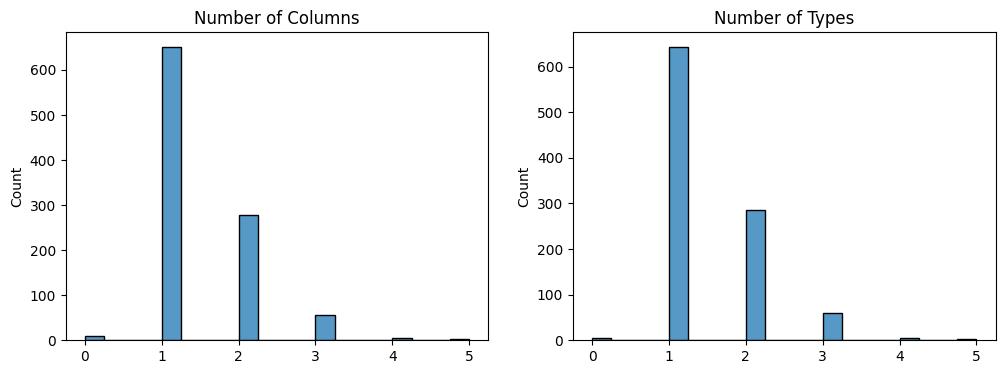

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

n_columns = []
n_types = []
for x in dev_plus:
    n_columns.append(len(x['gold_selection'][0]))
    n_types.append(len(x['gold_selection'][1]))

# distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(n_columns, bins=20)
plt.title('Number of Columns')
plt.subplot(1, 2, 2)
sns.histplot(n_types, bins=20)
plt.title('Number of Types')
plt.show()

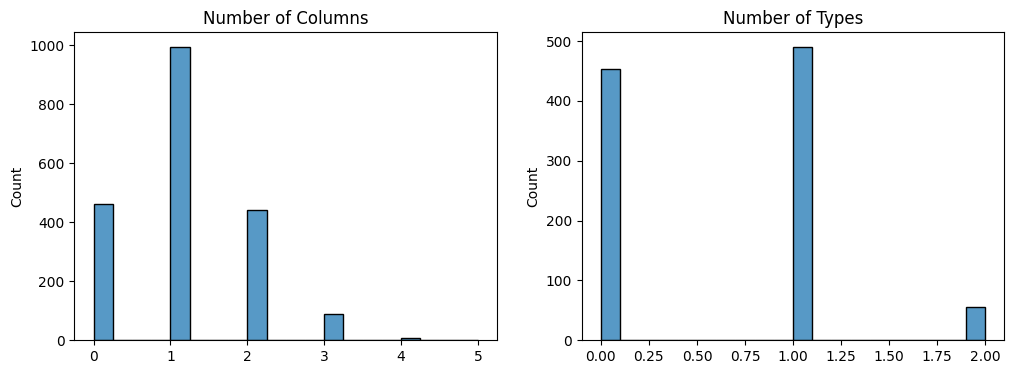

In [230]:
n_conds = []
n_types = []
for x in dev_plus:
    n_columns.append(len(x['gold_condition'][0]))
    n_types.append(len(x['gold_condition'][1]))

# distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(n_columns, bins=20)
plt.title('Number of Columns')
plt.subplot(1, 2, 2)
sns.histplot(n_types, bins=20)
plt.title('Number of Types')
plt.show()

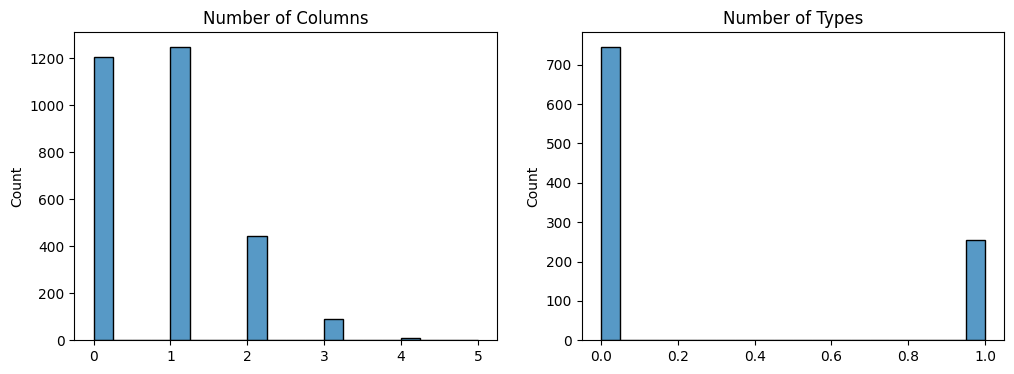

In [231]:
n_conds = []
n_types = []
for x in dev_plus:
    n_columns.append(len(x['gold_aggregation'][0]))
    n_types.append(len(x['gold_aggregation'][1]))

# distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(n_columns, bins=20)
plt.title('Number of Columns')
plt.subplot(1, 2, 2)
sns.histplot(n_types, bins=20)
plt.title('Number of Types')
plt.show()

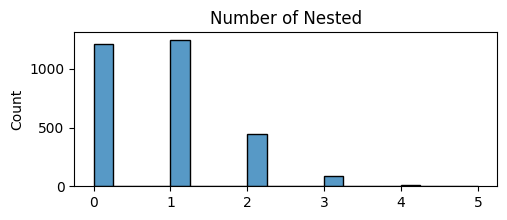

In [232]:
n_nested = []
for x in dev_plus:
    n_nested.append(x['gold_nested'])
# distribution
plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
sns.histplot(n_columns, bins=20)
plt.title('Number of Nested')
plt.show()

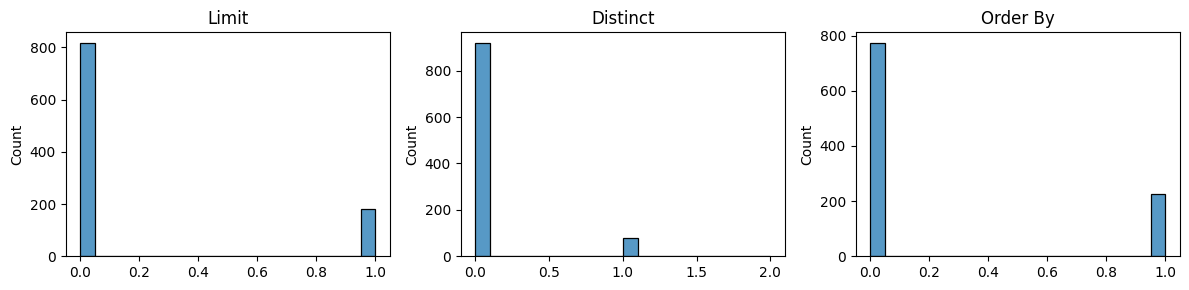

In [233]:
n_limit = []
n_distinct = []
n_orderby = []
for x in dev_plus:
    n_limit.append(x['gold_others']['limit'])
    n_distinct.append(len(x['gold_others']['distinct']))
    n_orderby.append(len(x['gold_others']['order by']))

# distribution
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
sns.histplot(n_limit, bins=20)  
plt.title('Limit')
plt.subplot(1, 3, 2)
sns.histplot(n_distinct, bins=20)
plt.title('Distinct')
plt.subplot(1, 3, 3)
sns.histplot(n_orderby, bins=20)
plt.title('Order By')
plt.tight_layout()
plt.show()

### Eval score

In [234]:
from typing import Optional

def partial_match(gold_set, predict_set):
    intersection = gold_set.intersection(predict_set)
    union = gold_set.union(predict_set)
    
    # IoU
    iou = len(intersection) / len(union) if union else 0
    
    # Precision
    precision = len(intersection) / len(predict_set) if predict_set else 0
    
    # Recall
    recall = len(intersection) / len(gold_set) if gold_set else 0
    
    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    
    return iou, precision, recall, f1_score

def derive_final_score(gold_sets: list, predict_sets: list):
    # Calculate F1-score for each aspect
    empty_gold = [False if g else True for g in gold_sets]
    if all(empty_gold):
        # If all gold sets are empty, return None
        return None
    f1_scores = []
    for i, (gold, pred) in enumerate(zip(gold_sets, predict_sets)):
        if not empty_gold[i]:
            *_, f1_score = partial_match(gold, pred)
            f1_scores.append(f1_score)
    assert len(f1_scores) > 0, 'No F1-score calculated'
    # modified weights if the gold set is empty

    weights = [1/len(f1_scores)]*len(f1_scores)
    weighted_f1_score = np.array(f1_scores) * np.array(weights)
    final_score = weighted_f1_score.sum()
    # Combine the scores using the specified weights
    return final_score

def normalize_values(x, min_value=0, max_value=6):
    normalized = (x - min_value) / (max_value - min_value)
    return normalized

def tanh(x: np.ndarray, k: float):
    normalized = normalize_values(x, max_value=k)
    return np.tanh(np.log(1+normalized.sum()))

def derive_complexity(x: list[int], k=6):
    score = tanh(np.array(x), k)
    return score

def eval_selection_aggregation_condition(gold: tuple[set, set], pred: tuple[set, set], k=6):
    # partial match
    final_score = derive_final_score(gold, pred)
    gold_complexity = derive_complexity([len(gold[0]), len(gold[1])], k)
    pred_complexity = derive_complexity([len(pred[0]), len(pred[1])], k)

    return final_score, gold_complexity, pred_complexity

def eval_nested(gold: int, pred: int, k=6):
    final_score = np.round(min(gold, pred) / (max(gold, pred) + 1e-10), 6)
    gold_complexity = derive_complexity([gold], k)
    pred_complexity = derive_complexity([pred], k)
    return final_score, gold_complexity, pred_complexity

def eval_others(gold: dict[str, set|bool], pred: dict[str, set|bool], k=6):
    # partial match
    gold_distinct = gold['distinct']
    pred_distinct = pred['distinct']
    gold_orderby = gold['order by']
    pred_orderby = pred['order by']
    gold_limit = set([int(gold['limit'])])
    pred_limit = set([int(pred['limit'])])
    
    final_score = derive_final_score(
        [gold_distinct, gold_orderby, gold_limit], 
        [pred_distinct, pred_orderby, pred_limit], 
    )
    gold_complexity = derive_complexity([len(gold_distinct), len(gold_orderby), len(gold_limit)], k)
    pred_complexity = derive_complexity([len(pred_distinct), len(pred_orderby), len(pred_limit)], k)

    return final_score, gold_complexity, pred_complexity
    
def eval_all(x, k=6):
    selection_score, selecton_gold_complexity, selection_pred_complexity = \
        eval_selection_aggregation_condition(x['gold_selection'], x['pred_selection'], k)
    condition_score, condition_gold_complexity, condition_pred_complexity = \
        eval_selection_aggregation_condition(x['gold_condition'], x['pred_condition'], k)
    aggregation_score, aggregation_gold_complexity, aggregation_pred_complexity = \
        eval_selection_aggregation_condition(x['gold_aggregation'], x['pred_aggregation'], k)
    nested_score, nested_gold_complexity, nested_pred_complexity = \
        eval_nested(x['gold_nested'], x['pred_nested'], k)
    others_score, others_gold_complexity, others_pred_complexity = \
        eval_others(x['gold_others'], x['pred_others'], k)
    
    results = {
        'score': {
            'selection': selection_score,
            'condition': condition_score,
            'aggregation': aggregation_score,
            'nested': nested_score,
            'others': others_score
        },
        'complexity': {
            'selection': [selecton_gold_complexity, selection_pred_complexity],
            'condition': [condition_gold_complexity, condition_pred_complexity],
            'aggregation': [aggregation_gold_complexity, aggregation_pred_complexity],
            'nested': [nested_gold_complexity, nested_pred_complexity],
            'others': [others_gold_complexity, others_pred_complexity]
        }
    }
    return results


In [235]:
def eval_all_dataset(data_plus: list[dict]):
    eval_results = []
    for x in tqdm(data_plus):
        results = eval_all(x)
        gold_c = np.mean([x[0] for x in results['complexity'].values()])
        pred_c = np.mean([x[1] for x in results['complexity'].values()])
        new_x = {
            'sample_id': x['sample_id'],
            'db_id': x['db_id'],
            'score': x['score'],
            'gold_sql': x['gold_sql'],
            'pred_sql': x['pred_sql'],
            'source_tables': x['source_tables'],
            'len_tbls': len(x['source_tables']),
            's_sel': results['score']['selection'],
            's_cond': results['score']['condition'],
            's_agg': results['score']['aggregation'],
            's_nest': results['score']['nested'],
            's_oth': results['score']['others'],
            'gold_c_sel': results['complexity']['selection'][0],
            'gold_c_cond': results['complexity']['condition'][0],
            'gold_c_agg': results['complexity']['aggregation'][0],
            'gold_c_nest': results['complexity']['nested'][0],
            'gold_c_oth': results['complexity']['others'][0],
            'pred_c_sel': results['complexity']['selection'][1],
            'pred_c_cond': results['complexity']['condition'][1],
            'pred_c_agg': results['complexity']['aggregation'][1],
            'pred_c_nest': results['complexity']['nested'][1],
            'pred_c_oth': results['complexity']['others'][1],
            'gold_c': gold_c,
            'pred_c': pred_c
        }
        eval_results.append(new_x)

    df = pd.DataFrame(eval_results)
    return df

df_eval_train = eval_all_dataset(train_plus)
df_eval_train.to_csv(proj_path / 'experiments' / 'evals' / 'spider_train_eval_plus.csv', index=False)
df_eval_dev = eval_all_dataset(dev_plus)
df_eval_dev.to_csv(proj_path / 'experiments' / 'evals' / 'spider_dev_eval_plus.csv', index=False)

  0%|          | 0/6786 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:00<00:00, 13806.74it/s]


### Experiments for functions

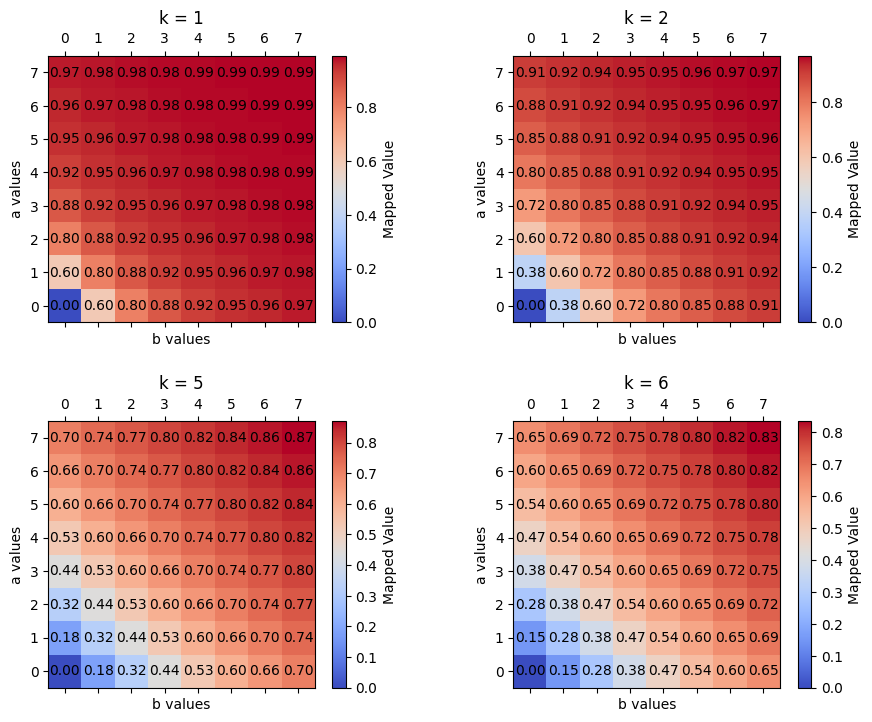

In [236]:
import matplotlib.pyplot as plt
import numpy as np

N = 8
a_values = np.arange(0, N, 1)  # Example range from 0 to 9
b_values = np.arange(0, N, 1)  # Example range from 0 to 9

# Create a matrix to hold the results
result_matrix = np.zeros((len(a_values), len(b_values)))
def normalize_values(x, min_value=0, max_value=5):
    normalized = (x - min_value) / (max_value - min_value)
    return normalized

def tanh(x: np.ndarray, k: float):
    normalized = normalize_values(x, max_value=k)
    return np.tanh(np.log(1+normalized.sum()))

def archtan(x: np.ndarray, k: float):
    normalized = normalize_values(x, max_value=k)
    return (2 / np.pi) * np.arctan(normalized.sum())

def sigmoid(x: np.ndarray, k: float=0.1):
    # sigmoid function
    normalized = normalize_values(x, min_value=-k, max_value=k)
    return 1 / (1 + np.exp(-normalized.sum()))

def exponential(x: np.ndarray, k: float=0.1):
    normalized = normalize_values(x, max_value=k)
    return np.exp(-normalized.sum())

func_name = 'tanh'
func = {
    'tanh': tanh,
    'archtan': archtan,
    'sigmoid': sigmoid,
    'exponential': exponential
}[func_name]

result_matrices = {}

ks = [1, 2, 5, 6]
# Populate the matrix with the new function values
for k in ks:
    result_matrices[k] = np.zeros((len(a_values), len(b_values)))
    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            result_matrices[k][i, j] = func(np.array([a, b]), k)

# Plot the matrix for the new function
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.tight_layout(pad=5.0)

for i, (k, ax) in enumerate(zip(ks, axes.flatten())):
    # contourf
    # contour = ax.contourf(b_values, a_values, result_matrices[k], levels=50, cmap='viridis')
    matshow = ax.matshow(result_matrices[k], cmap='coolwarm')
    ax.set_title(f'k = {k}')
    ax.set_xlabel('b values')
    ax.set_ylabel('a values')
    ax.invert_yaxis()
    # add numbering 
    for (i, j), val in np.ndenumerate(result_matrices[k]):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
    # Add color bar for each plot
    cbar = fig.colorbar(matshow, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Mapped Value')

plt.show()

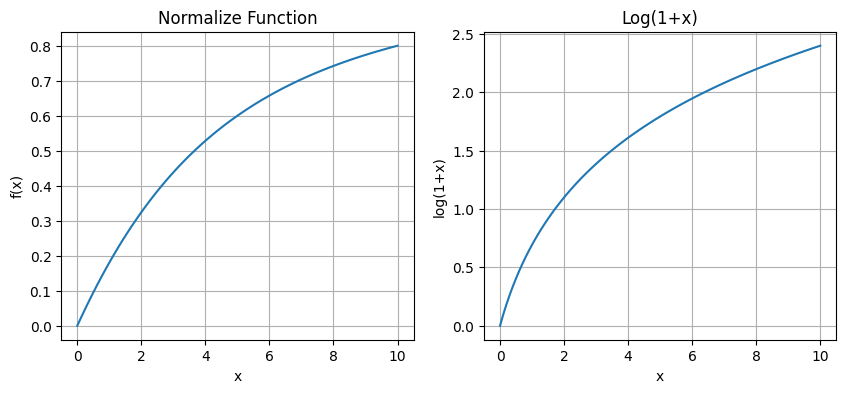

In [237]:
# plot tanh graph

xx = np.linspace(0, 10, 100)
yy = [tanh(x, 5) for x in xx]
yy2 = np.log(1 + xx)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(xx, yy)
axes[0].set_title('Normalize Function')
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].grid()

axes[1].plot(xx, yy2)
axes[1].set_title('Log(1+x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('log(1+x)')
axes[1].grid()

plt.show()

# Final Analysis

In [254]:
df1 = pd.read_csv(proj_path / 'experiments' / 'evals' / 'spider_train_eval_plus.csv')
df1['sample_id'] = 'train.' + df1['sample_id'].astype(str)
df2 = pd.read_csv(proj_path / 'experiments' / 'evals' / 'spider_dev_eval_plus.csv')
df2['sample_id'] = 'dev.' + df2['sample_id'].astype(str)
df = pd.concat([df1, df2]).reset_index(drop=True)

df['cate_len_tbls'] = pd.cut(df['len_tbls'], bins=[0, 1, 2, 10], labels=['1', '2', '3+'])

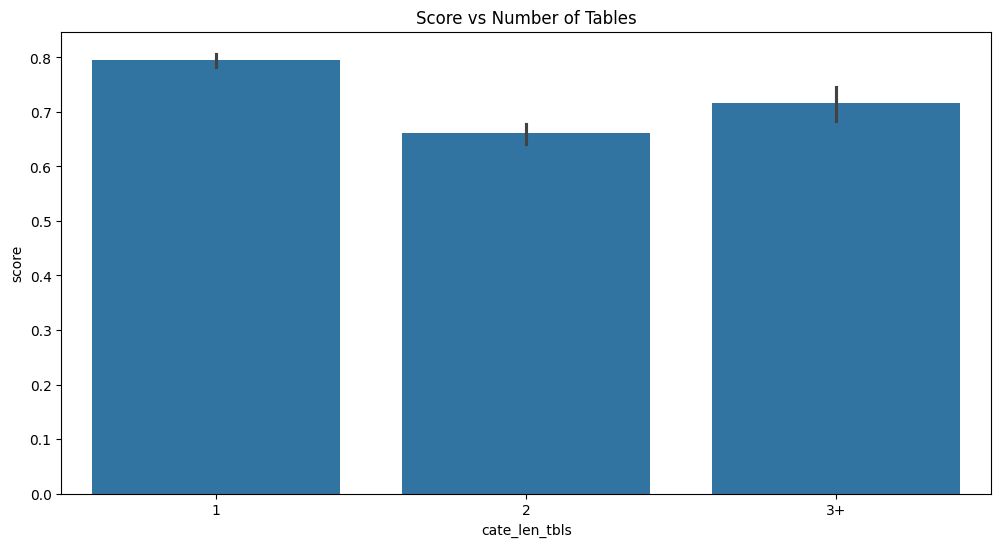

In [255]:
# complexity vs score (group by tables)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x='cate_len_tbls', y='score', data=df, ax=ax)
ax.set_title('Score vs Number of Tables')
plt.show()

* The number of tables is not the only factor that affects the score to generate the SQL query.

#### Complexity Analysis 

* To argue we should use the complexity of SQL query to evaluate the difficulty of the question.
* Can be candidates for the hueristic method to select BO.

In [256]:
df.loc[:, ['gold_c', 'pred_c', 'gold_c_sel', 'pred_c_sel', 'gold_c_cond', 'pred_c_cond', 'gold_c_agg', 'pred_c_agg', 'gold_c_nest', 'pred_c_nest', 'gold_c_oth', 'pred_c_oth']].describe()

,gold_c,pred_c,gold_c_sel,pred_c_sel,gold_c_cond,pred_c_cond,gold_c_agg,pred_c_agg,gold_c_nest,pred_c_nest,gold_c_oth,pred_c_oth
count,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000,7785.000000
mean,0.162968,0.164896,0.345592,0.351559,0.185057,0.199843,0.068648,0.070221,0.020852,0.000814,0.194689,0.202042
std,0.045650,0.047117,0.115432,0.120459,0.174303,0.176976,0.121230,0.129890,0.073398,0.014828,0.061709,0.065906
min,0.030588,0.030588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152941,0.152941
25%,0.142588,0.142588,0.280000,0.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152941,0.152941
50%,0.163511,0.168000,0.280000,0.280000,0.280000,0.280000,0.000000,0.000000,0.000000,0.000000,0.152941,0.152941
75%,0.180706,0.188923,0.470588,0.470588,0.280000,0.280000,0.000000,0.000000,0.000000,0.000000,0.280000,0.280000
max,0.370868,0.378868,0.800000,0.834862,0.648780,0.689655,0.600000,0.689655,0.384615,0.280000,0.470588,0.470588


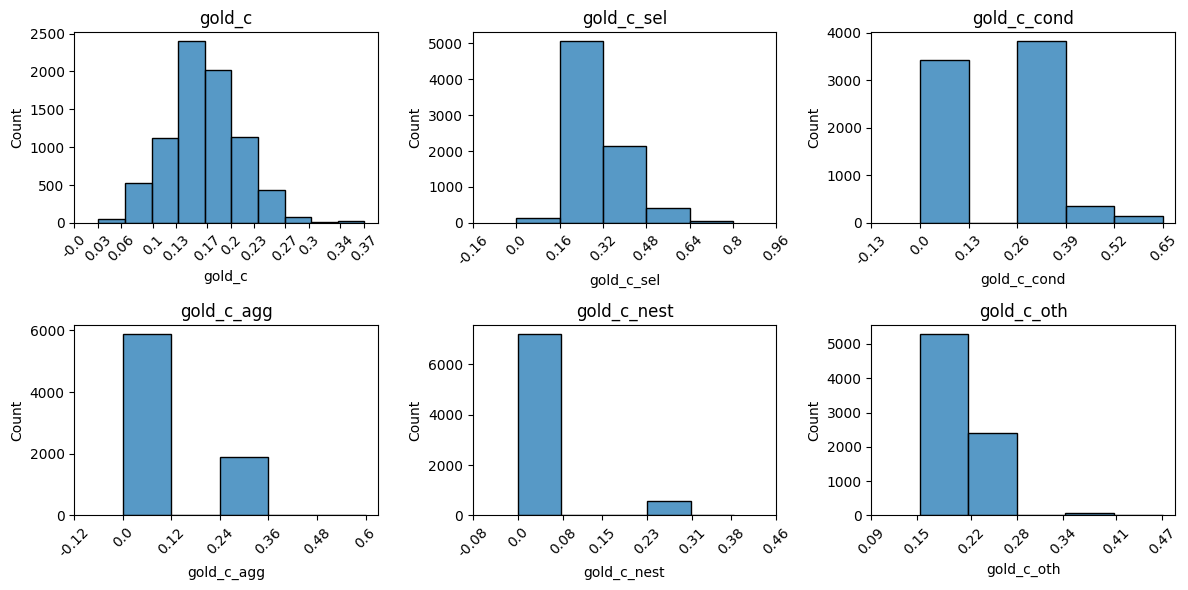

In [257]:
# distribution of target SQL complexity
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, (col, ax, n_bins) in enumerate(zip(['gold_c', 'gold_c_sel', 'gold_c_cond', 'gold_c_agg', 'gold_c_nest', 'gold_c_oth'], axes.flatten(), [10, 5, 5, 5, 5, 5])):
    min_val = df[col].min()
    max_val = df[col].max()
    val_width = max_val - min_val
    bin_width = val_width / n_bins
    sns.histplot(df[col], bins=n_bins, ax=ax, binrange=(min_val, max_val))
    ax.set_title(col)
    ax.set_xticks(np.arange(min_val-bin_width, max_val+bin_width, bin_width).round(2))
    ax.set_xticklabels(np.arange(min_val-bin_width, max_val+bin_width, bin_width).round(2), rotation=45)
plt.tight_layout()
plt.show()

In [258]:
for x in ['gold', 'pred']:
    c_max = df[f'{x}_c'].max()
    c_min = df[f'{x}_c'].min()
    c_avg = df[f'{x}_c'].mean()
    c_med = df[f'{x}_c'].median()
    df[f'cate_{x}_c'] = pd.cut(df[f'{x}_c'], bins=[-1, c_avg, 1], labels=[f'low(<{c_avg:.4f})', f'high(>={c_avg:.4f})'])
    for c in ['sel', 'cond', 'agg', 'nest', 'oth']:
        c_max = df[f'{x}_c_{c}'].max()
        c_min = df[f'{x}_c_{c}'].min()
        c_avg = df[f'{x}_c_{c}'].mean()
        c_med = df[f'{x}_c_{c}'].median()
        df[f'cate_{x}_c_{c}'] = pd.cut(df[f'{x}_c_{c}'], bins=[-1, c_avg, 1], labels=[f'low(<{c_avg:.4f})', f'high(>={c_avg:.4f})'])

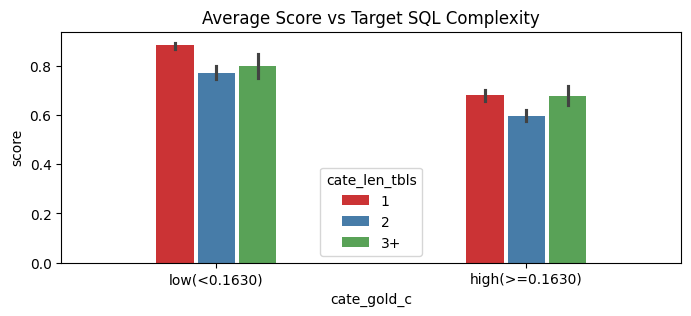

In [259]:
cols = ['cate_gole_c', 'cate_pred_c']
title = 'Average Score vs Target SQL Complexity'
palette = sns.color_palette("Set1", 3)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.barplot(x='cate_gold_c', y='score', hue='cate_len_tbls', data=df, ax=ax, palette=palette, width=0.4, gap=0.1)
ax.set_title(title)
plt.show()

* higher complexity tends to have a lower score.

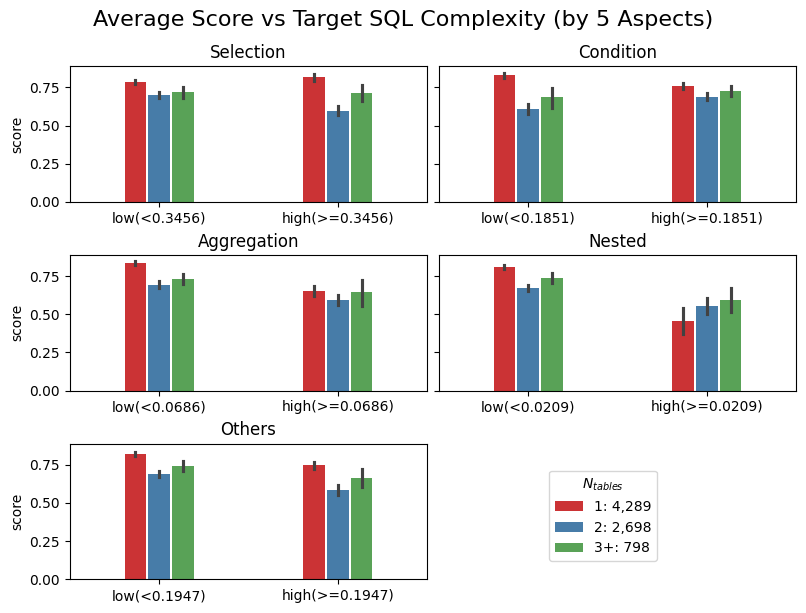

In [260]:
cols = ['cate_gold_c_sel', 'cate_gold_c_cond', 'cate_gold_c_agg', 'cate_gold_c_nest', 'cate_gold_c_oth']
xaxis_labels = ['Selection', 'Condition', 'Aggregation', 'Nested', 'Others']
title = 'Average Score vs Target SQL Complexity (by 5 Aspects)'
palette = sns.color_palette("Set1", 3)
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharey=True)
axes.flatten()[-1].remove()
for i, c in enumerate(cols):
    ax = axes.flatten()[i]
    sns.barplot(x=c, y='score', data=df, hue='cate_len_tbls', errorbar=('ci', 95), palette=palette, ax=ax, legend=True, dodge=True, width=0.4, gap=0.1)  # ('ci', 95)
    ax.set_xlabel('')
    ax.legend_.remove()
    ax.set_title(xaxis_labels[i])

handles, _ = plt.gca().get_legend_handles_labels()
labels = list(map(lambda x: f'{x[0]}: {x[1]:,}', df['cate_len_tbls'].value_counts().to_dict().items()))
fig.suptitle(title, fontsize=16, y=1.0)
fig.legend(handles, labels, title='$N_{tables}$', loc='lower center', bbox_to_anchor=(0.75, 0.07))
plt.tight_layout(pad=0.5)
plt.show()

* All the low/high complexity is divided by the average of that complexity.
* when increasing the numbers of table, higher complexity tends to have a lower score in Aggregation, Nested, and Others.

In [261]:
df['s_nest'].describe()

count    7785.000000
mean        0.002762
std         0.052176
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: s_nest, dtype: float64

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

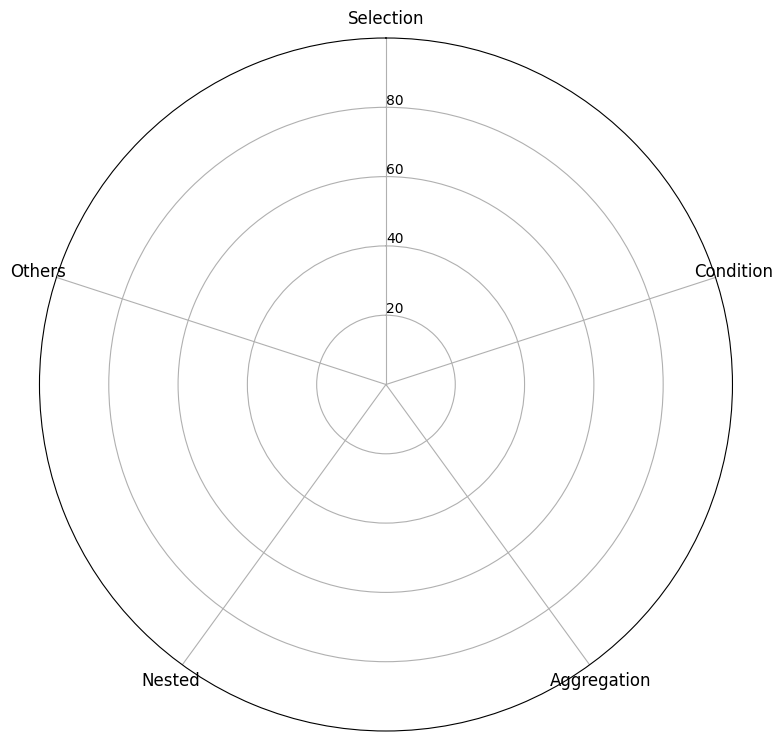

In [246]:
import numpy as np
import matplotlib.pyplot as plt

title = 'Partial Match F1-Score'

df_len_tbls_score = df.groupby(['cate_len_tbls'], observed=False)[['s_sel', 's_cond', 's_agg', 's_nest', 's_oth']].mean()
df_draw = (df_len_tbls_score*100).fillna(0).round(6)
df_n_qs = df.groupby(['cate_len_tbls'], observed=False).size().reset_index(name='n_question').set_index('cate_len_tbls')
cate = df_n_qs.index.tolist()
palette = sns.color_palette("Set1", len(df_draw))

# Aspects and their values
aspects = ['Selection', 'Condition', 'Aggregation', 'Nested', 'Others']
N = len(aspects)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.rc('figure', figsize=(9, 9))
ax = plt.subplot(1, 1, 1, polar=True)
 
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], aspects, color='black', size=12)
ax.tick_params(axis='x', rotation=0)

ax.set_rlabel_position(0)
plt.yticks([20,40,60,80], ["20","40","60","80"], color="black", size=10)
plt.ylim(0,100)

for idx in range(len(df_draw)):
    values=df_draw.loc[cate[idx]].values.tolist()[1:]
    values += values[:1]
    label = '$N_{table}$: ' + f'{cate[idx]}' + ' - ' + '$N_{question}$: ' + f'{df_n_qs.loc[cate[idx]].values[0]:,}'
    ax.plot(angles, values, color = palette[idx], linewidth=1, linestyle='solid', label=label)
    # ax.fill(angles, values, color = palette[idx], alpha = 0.1, label=label)

ax.set_title(title, fontsize=20, x = 0.5, y = 1.05)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.show()

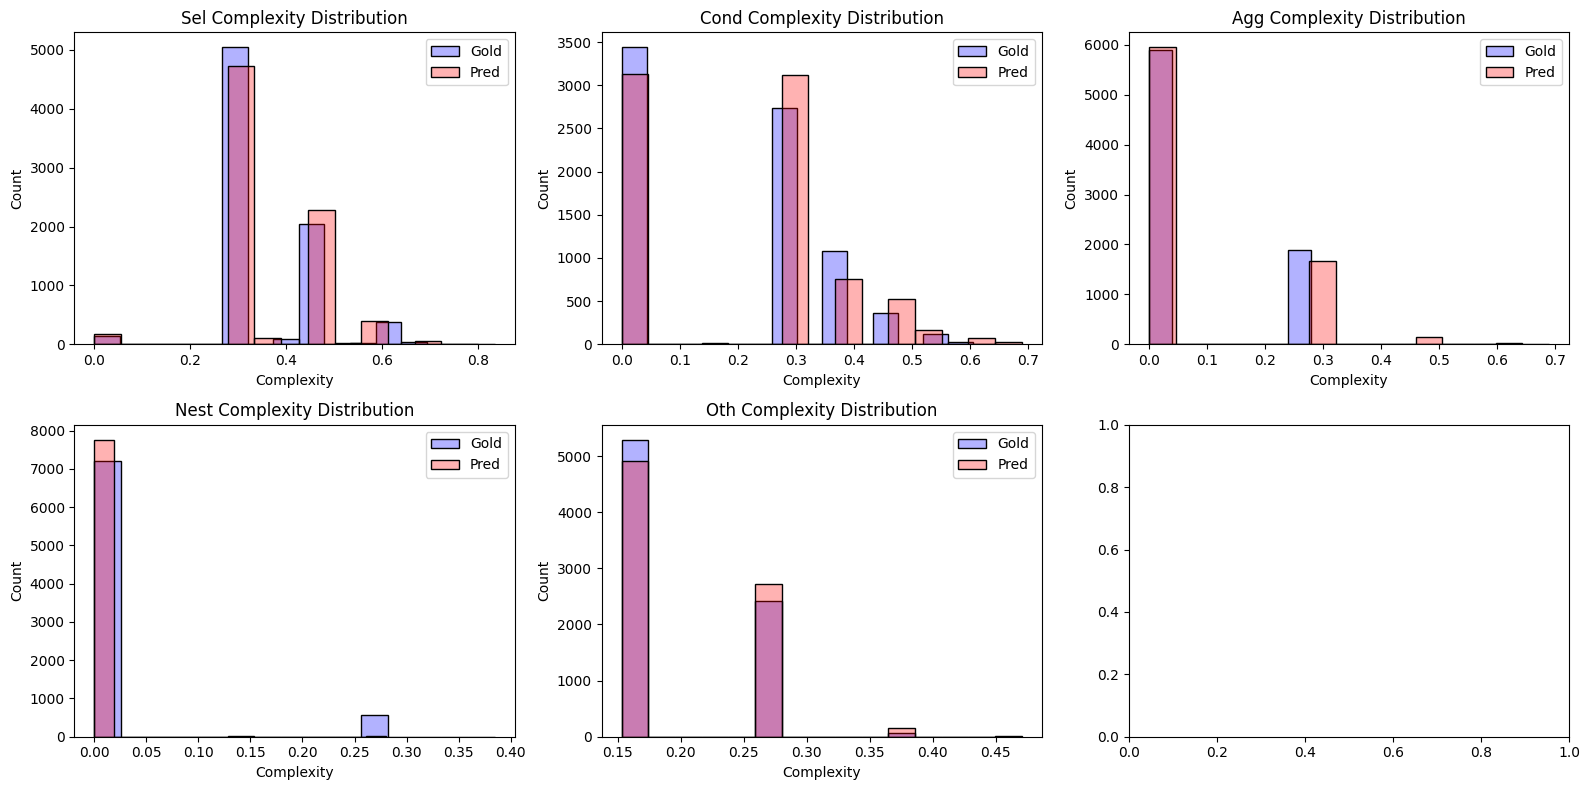

In [173]:
# prediction complexity
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, (aspect, ax) in enumerate(zip(['sel', 'cond', 'agg', 'nest', 'oth'], axes.flatten())):
    sns.histplot(df[f'gold_c_{aspect}'], bins=15, color='blue', alpha=0.3, label='Gold', kde=False, ax=ax)
    sns.histplot(df[f'pred_c_{aspect}'], bins=15, color='red', alpha=0.3, label='Pred', kde=False, ax=ax)
    ax.set_title(f'{aspect.capitalize()} Complexity Distribution')
    ax.set_xlabel('Complexity')
    ax.legend()

plt.tight_layout()
plt.show()

In [355]:
df.groupby(['db_id', 'len_tbls'])[['s_sel', 's_cond', 's_agg', 's_nest', 's_oth']].mean().round(4)

s_sel  s_cond   s_agg  s_nest   s_oth
db_id      len_tbls                                        
activity_1 1         0.8875  0.5823  1.0000     NaN  0.9500
           2         0.7244  0.4167  0.6500  0.0833  0.8750
           3         0.2500  0.1667     NaN  0.0000  0.7500
aircraft   1         1.0000  0.7500     NaN     NaN  0.9091
           2         0.7143  0.4688  0.0000     NaN  0.8214
...                     ...     ...     ...     ...     ...
world_1    3         1.0000  0.4167     NaN     NaN  0.5000
wrestler   1         0.9028  0.5357  1.0000  0.0000  0.9464
           2         1.0000  0.7500     NaN     NaN  0.8000
wta_1      1         0.8714  0.6427  0.8571  0.0000  0.9094
           2         0.9500  0.4167  0.8333  0.0000  0.9000

[440 rows x 5 columns]

In [356]:
df.groupby(['len_tbls'])[['score', 's_sel', 's_cond', 's_agg', 's_nest', 's_oth']].agg(['mean', 'count'])

score           s_sel          s_cond           s_agg        \
              mean count      mean count      mean count      mean count   
len_tbls                                                                   
1         0.795523  4289  0.880862  4173  0.619245  1994  0.859985   913   
2         0.660860  2698  0.813511  2677  0.477209  1730  0.345799   861   
3         0.716253   726  0.833059   721  0.449911   562  0.498575   117   
4         0.765625    64  0.854762    64  0.434591    53  0.000000     7   
5         0.375000     8  1.000000     8  0.166667     6       NaN     0   

            s_nest           s_oth        
              mean count      mean count  
len_tbls                                  
1         0.020000   150  0.917114  4289  
2         0.043689   309  0.874969  2698  
3         0.042735   117  0.860882   726  
4         0.000000     6  0.898438    64  
5         0.000000     2  0.812500     8

NameError: name 'label' is not defined

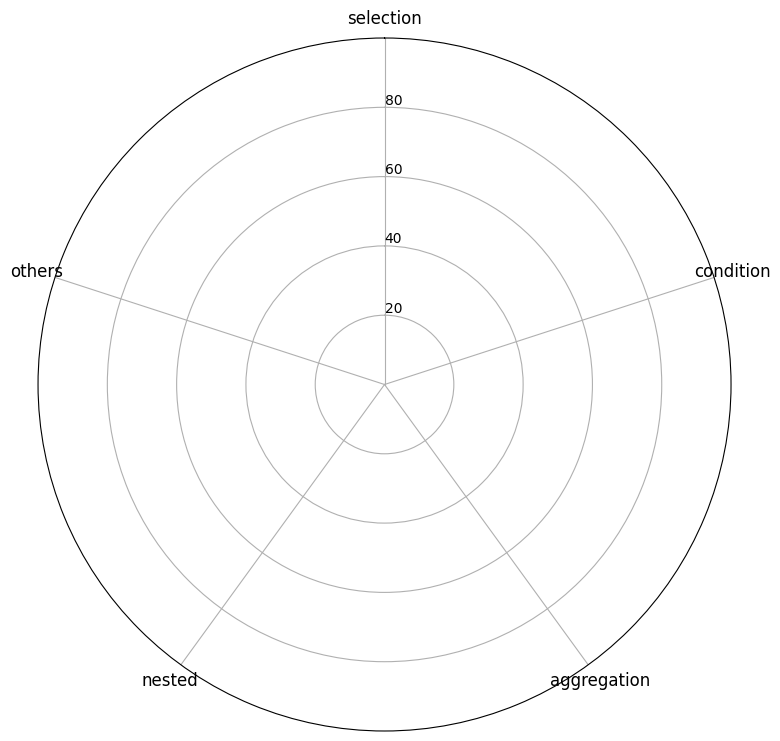

In [418]:
df.columns

Index(['sample_id', 'db_id', 'score', 'gold_sql', 'pred_sql', 'source_tables',
       'len_tbls', 's_sel', 's_cond', 's_agg', 's_nest', 's_oth', 'gold_c_sel',
       'gold_c_cond', 'gold_c_agg', 'gold_c_nest', 'gold_c_oth', 'pred_c_sel',
       'pred_c_cond', 'pred_c_agg', 'pred_c_nest', 'pred_c_oth', 'gold_c',
       'pred_c'],
      dtype='object')

In [422]:
df.groupby(['len_tbls'])[['gold_c_sel', 'gold_c_cond', 'gold_c_agg', 'gold_c_nest', 'gold_c_oth']].agg(['mean', 'count', 'max'])

gold_c_sel                 gold_c_cond                 gold_c_agg  \
               mean count       max        mean count       max       mean   
len_tbls                                                                     
1          0.335201  4289  0.753425    0.150371  4289  0.648780   0.059959   
2          0.359872  2698  0.800000    0.215586  2698  0.600000   0.089756   
3          0.352981   726  0.753425    0.264010   726  0.648780   0.045649   
4          0.351515    64  0.689655    0.320575    64  0.600000   0.030625   
5          0.382414     8  0.689655    0.236154     8  0.384615   0.000000   

                         gold_c_nest                 gold_c_oth        \
         count       max        mean count       max       mean count   
len_tbls                                                                
1         4289  0.470588    0.009644  4289  0.280000   0.197566  4289   
2         2698  0.600000    0.031863  2698  0.384615   0.190932  2698   
3          726  0.470588    0.045124   726  0.280000   0.193173   726   
4           64  0.280000    0.026250    64  0.280000   0.178750    64   
5            8  0.000000    0.070000     8  0.280000   0.184706     8   

                    
               max  
len_tbls            
1         0.384615  
2         0.384615  
3         0.470588  
4         0.280000  
5         0.280000

In [ ]:
title = 'Partial Match F1-Score'

df_len_tbls_score = df.groupby(['len_tbls'])[['s_sel', 's_cond', 's_agg', 's_nest', 's_oth']].mean()
df_draw = (df_len_tbls_score*100).fillna(0).round(6)
df_n_qs = df.groupby(['len_tbls']).size().reset_index(name='n_question').set_index('len_tbls')

palette = sns.color_palette("Set1", len(df_draw))

# Factors and their values
factors = ['selection', 'condition', 'aggregation', 'nested', 'others']
N = len(factors)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.rc('figure', figsize=(9, 9))
ax = plt.subplot(1, 1, 1, polar=True)
 
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], factors, color='black', size=12)
ax.tick_params(axis='x', rotation=0)

ax.set_rlabel_position(0)
plt.yticks([20,40,60,80], ["20","40","60","80"], color="black", size=10)
plt.ylim(0,100)

for idx in range(len(df_draw)):
    values=df_draw.reset_index().loc[idx].values.tolist()[1:]
    values += values[:1]

    ax.plot(angles, values, color = palette[idx], linewidth=1, linestyle='solid')
    label = '$N_{table}$: ' + f'{idx+1}' + ' - ' + '$N_{question}$: ' + f'{df_n_qs.loc[idx+1].values[0]:,}'
    ax.fill(angles, values, color = palette[idx], alpha = 0.1, label=label)

ax.set_title(title, fontsize=20, x = 0.5, y = 1.05)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.show()

---

In [29]:
def apply_func(x: int, k: int) -> int:
    if x > k:
        return f'{k}+'
    return f'{x}'

df_train_results = pd.read_csv(eval_path / 'spider_train_eval.csv')
df_dev_results = pd.read_csv(eval_path / 'spider_dev_eval.csv')

# df_train_results['selection'] = df_train_results['selection'].apply(apply_func, k=2)
# df_train_results['condition'] = df_train_results['condition'].apply(apply_func, k=2)
# df_train_results['aggregation'] = df_train_results['aggregation'].apply(apply_func, k=1)
# df_train_results['ordering'] = df_train_results['ordering'].apply(apply_func, k=1)
# df_dev_results['selection'] = df_dev_results['selection'].apply(apply_func, k=2)
# df_dev_results['condition'] = df_dev_results['condition'].apply(apply_func, k=2)
# df_dev_results['aggregation'] = df_dev_results['aggregation'].apply(apply_func, k=1)
# df_dev_results['ordering'] = df_dev_results['ordering'].apply(apply_func, k=1)

In [32]:
df_train_results.loc[df_train_results['db_id']=='college_2'].groupby(['len_tbls'])['score'].agg(['mean', 'count', 'sum'])

,mean,count,sum
len_tbls,,,
1,0.836538,104,87
2,0.795455,44,35
3,0.600000,20,12
4,1.000000,2,2


In [45]:
# nested vs non-nested
def print_nested_vs_non_nested(df: pd.DataFrame, typ: str = 'train'):
    nested = df[df['is_nested']]
    non_nested = df[~df['is_nested']]
    print(f'Nested {typ}: {nested["score"].mean()*100:.2f}% | Non-Nested {typ}: {non_nested["score"].mean()*100:.2f}%')

print_nested_vs_non_nested(df_train_results, 'train')
print_nested_vs_non_nested(df_dev_results, 'dev')

Nested train: 64.98% | Non-Nested train: 75.56%
Nested dev: 63.06% | Non-Nested dev: 77.49%


In [46]:
def print_each_component(df: pd.DataFrame, category: str, typ: str = 'train'):
    res = df.groupby(['len_tbls', category])['score'].agg(['mean', 'count', 'sum'])
    res['mean'] = res['mean']*100
    title = f'{category.capitalize()} {typ}: (# of tables, # of {category})'
    print(title)
    print(res.to_markdown())
    print()

# ('selection', 'condition', 'aggregation', 'ordering', 'limitation')

In [47]:
# selection
print_each_component(df_train_results, 'selection', 'train')
# print()
print_each_component(df_dev_results, 'selection', 'dev')

Selection train: (# of tables, # of selection)
|           |     mean |   count |   sum |
|:----------|---------:|--------:|------:|
| (1, '1')  |  79.0507 |    2444 |  1932 |
| (1, '2')  |  79.75   |    1200 |   957 |
| (1, '2+') |  75.4386 |     285 |   215 |
| (2, '1')  |  69.2771 |     996 |   690 |
| (2, '2')  |  65.6881 |    1090 |   716 |
| (2, '2+') |  52.2088 |     249 |   130 |
| (3, '1')  |  77.4481 |     337 |   261 |
| (3, '2')  |  70.6564 |     259 |   183 |
| (3, '2+') |  69.0141 |      71 |    49 |
| (4, '1')  |  74.1935 |      31 |    23 |
| (4, '2')  |  88.2353 |      17 |    15 |
| (4, '2+') |  60      |      10 |     6 |
| (5, '1')  | 100      |       2 |     2 |
| (5, '2')  |   0      |       4 |     0 |
| (5, '2+') |  50      |       2 |     1 |

Selection dev: (# of tables, # of selection)
|           |    mean |   count |   sum |
|:----------|--------:|--------:|------:|
| (1, '1')  | 83.9286 |     336 |   282 |
| (1, '2')  | 77.7778 |     198 |   154 |
| (1, '2

In [48]:
# condition
print_each_component(df_train_results, 'condition', 'train')
# print()
print_each_component(df_dev_results, 'condition', 'dev')

Condition train: (# of tables, # of condition)
|           |     mean |   count |   sum |
|:----------|---------:|--------:|------:|
| (1, '0')  |  82.4268 |    2151 |  1773 |
| (1, '1')  |  77.7441 |    1321 |  1027 |
| (1, '2')  |  68.0488 |     410 |   279 |
| (1, '2+') |  53.1915 |      47 |    25 |
| (2, '0')  |  60.2923 |     821 |   495 |
| (2, '1')  |  73.9212 |    1066 |   788 |
| (2, '2')  |  57.7215 |     395 |   228 |
| (2, '2+') |  47.1698 |      53 |    25 |
| (3, '0')  |  69.863  |     146 |   102 |
| (3, '1')  |  77.8788 |     330 |   257 |
| (3, '2')  |  73.743  |     179 |   132 |
| (3, '2+') |  16.6667 |      12 |     2 |
| (4, '0')  |  54.5455 |      11 |     6 |
| (4, '1')  |  82.3529 |      17 |    14 |
| (4, '2')  |  75      |      24 |    18 |
| (4, '2+') | 100      |       6 |     6 |
| (5, '0')  |  50      |       2 |     1 |
| (5, '1')  |  50      |       4 |     2 |
| (5, '2')  |   0      |       2 |     0 |

Condition dev: (# of tables, # of condition)
|   

In [49]:
# aggregation
print_each_component(df_train_results, 'aggregation', 'train')
# print()
print_each_component(df_dev_results, 'aggregation', 'dev')

Aggregation train: (# of tables, # of aggregation)
|           |    mean |   count |   sum |
|:----------|--------:|--------:|------:|
| (1, '0')  | 83.4441 |    3008 |  2510 |
| (1, '1')  | 64.8291 |     907 |   588 |
| (1, '1+') | 42.8571 |      14 |     6 |
| (2, '0')  | 68.7071 |    1601 |  1100 |
| (2, '1')  | 59.4744 |     723 |   430 |
| (2, '1+') | 54.5455 |      11 |     6 |
| (3, '0')  | 75.0446 |     561 |   421 |
| (3, '1')  | 67.0103 |      97 |    65 |
| (3, '1+') | 77.7778 |       9 |     7 |
| (4, '0')  | 76.4706 |      51 |    39 |
| (4, '1')  | 71.4286 |       7 |     5 |
| (5, '0')  | 50      |       6 |     3 |
| (5, '1')  |  0      |       2 |     0 |

Aggregation dev: (# of tables, # of aggregation)
|           |    mean |   count |   sum |
|:----------|--------:|--------:|------:|
| (1, '0')  | 85.7143 |     455 |   390 |
| (1, '1')  | 68.6441 |     118 |    81 |
| (2, '0')  | 74.8988 |     247 |   185 |
| (2, '1')  | 60.274  |     146 |    88 |
| (3, '0')  | 48.

In [50]:
# is_nested
print_each_component(df_train_results, 'is_nested', 'train')
# print()
print_each_component(df_dev_results, 'is_nested', 'dev')

Is_nested train: (# of tables, # of is_nested)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (1, False) | 80.5356 |    3622 |  2917 |
| (1, True)  | 60.9121 |     307 |   187 |
| (2, False) | 64.9972 |    1797 |  1168 |
| (2, True)  | 68.4015 |     538 |   368 |
| (3, False) | 77.6923 |     520 |   404 |
| (3, True)  | 60.5442 |     147 |    89 |
| (4, False) | 71.7391 |      46 |    33 |
| (4, True)  | 91.6667 |      12 |    11 |
| (5, False) | 75      |       4 |     3 |
| (5, True)  |  0      |       4 |     0 |

Is_nested dev: (# of tables, # of is_nested)
|            |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| (1, False) | 83.3948 |     542 |   452 |
| (1, True)  | 61.2903 |      31 |    19 |
| (2, False) | 70.3448 |     290 |   204 |
| (2, True)  | 66.9903 |     103 |    69 |
| (3, False) | 45.9459 |      37 |    17 |
| (3, True)  | 47.8261 |      23 |    11 |
| (4, False) | 83.3333 |       6 |     5 |



In [51]:
df_train_results['is_nested_setop'] = df_train_results['is_nested_intersect'] | df_train_results['is_nested_except'] | df_train_results['is_nested_union']
df_dev_results['is_nested_setop'] = df_dev_results['is_nested_intersect'] | df_dev_results['is_nested_except'] | df_dev_results['is_nested_union']

df_train_results.groupby(['len_tbls', 'is_nested_where',
       'is_nested_having', 'is_nested_setop'])['score'].agg(['mean', 'count'])

mean  count
len_tbls is_nested_where is_nested_having is_nested_setop                 
1        False           False            False            0.805356   3622
                                          True             0.463235    136
                         True             False            0.500000      4
         True            False            False            0.739394    165
                                          True             0.000000      2
2        False           False            False            0.649972   1797
                                          True             0.554688    256
                         True             False            0.000000      1
         True            False            False            0.815884    277
                                          True             0.000000      4
3        False           False            False            0.776923    520
                                          True             0.580000    100
         True            False            False            0.644444     45
                                          True             1.000000      2
4        False           False            False            0.717391     46
                                          True             1.000000      6
         True            False            False            0.833333      6
5        False           False            False            0.750000      4
                                          True             0.000000      2
         True            False            False            0.000000      2

In [52]:
# ordering
print_each_component(df_train_results, 'ordering', 'train')
# print()
print_each_component(df_dev_results, 'ordering', 'dev')

Ordering train: (# of tables, # of ordering)
|          |    mean |   count |   sum |
|:---------|--------:|--------:|------:|
| (1, '0') | 82.7114 |    2921 |  2416 |
| (1, '1') | 68.254  |    1008 |   688 |
| (2, '0') | 67.7524 |    1842 |  1248 |
| (2, '1') | 58.4178 |     493 |   288 |
| (3, '0') | 75.365  |     548 |   413 |
| (3, '1') | 67.2269 |     119 |    80 |
| (4, '0') | 78.1818 |      55 |    43 |
| (4, '1') | 33.3333 |       3 |     1 |
| (5, '0') | 50      |       6 |     3 |
| (5, '1') |  0      |       2 |     0 |

Ordering dev: (# of tables, # of ordering)
|          |    mean |   count |   sum |
|:---------|--------:|--------:|------:|
| (1, '0') | 85.7466 |     442 |   379 |
| (1, '1') | 70.229  |     131 |    92 |
| (2, '0') | 71.8644 |     295 |   212 |
| (2, '1') | 62.2449 |      98 |    61 |
| (3, '0') | 44.4444 |      54 |    24 |
| (3, '1') | 66.6667 |       6 |     4 |
| (4, '0') | 83.3333 |       6 |     5 |



In [53]:
# limitation
print_each_component(df_train_results, 'limitation', 'train')
# print()
print_each_component(df_dev_results, 'limitation', 'dev')

Limitation train: (# of tables, # of limitation)
|        |    mean |   count |   sum |
|:-------|--------:|--------:|------:|
| (1, 0) | 83.2733 |    3330 |  2773 |
| (1, 1) | 55.2588 |     599 |   331 |
| (2, 0) | 67.3618 |    1918 |  1292 |
| (2, 1) | 58.5132 |     417 |   244 |
| (3, 0) | 76.0274 |     584 |   444 |
| (3, 1) | 59.0361 |      83 |    49 |
| (4, 0) | 78.1818 |      55 |    43 |
| (4, 1) | 33.3333 |       3 |     1 |
| (5, 0) | 50      |       6 |     3 |
| (5, 1) |  0      |       2 |     0 |

Limitation dev: (# of tables, # of limitation)
|        |    mean |   count |   sum |
|:-------|--------:|--------:|------:|
| (1, 0) | 84.6473 |     482 |   408 |
| (1, 1) | 69.2308 |      91 |    63 |
| (2, 0) | 71.9064 |     299 |   215 |
| (2, 1) | 61.7021 |      94 |    58 |
| (3, 0) | 46.4286 |      56 |    26 |
| (3, 1) | 50      |       4 |     2 |
| (4, 0) | 83.3333 |       6 |     5 |



In [36]:
# definition from the spider dataset
def print_hardness(df: pd.DataFrame, typ: str = 'train'):
    res = df.groupby(['hardness'])['score'].agg(
        ['mean', 'count', 'sum']).reindex(['easy', 'medium', 'hard', 'extra'], level=1)
    res['mean'] = res['mean']*100
    print(f'Hardness {typ}: (is_nested, hardness)')
    print(res.to_markdown())

print_hardness(df_train_results, 'train')
print()
print_hardness(df_dev_results, 'dev')

Hardness train: (is_nested, hardness)
| hardness   |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| easy       | 87.3105 |    1781 |  1555 |
| medium     | 75.9619 |    2729 |  2073 |
| hard       | 61.835  |    1297 |   802 |
| extra      | 63.0252 |    1190 |   750 |

Hardness dev: (is_nested, hardness)
| hardness   |    mean |   count |   sum |
|:-----------|--------:|--------:|------:|
| easy       | 89.3701 |     254 |   227 |
| medium     | 79.6804 |     438 |   349 |
| hard       | 57.8231 |     147 |    85 |
| extra      | 60.1036 |     193 |   116 |


In [19]:
df_train_results.columns

Index(['sample_id', 'db_id', 'score', 'gold_sql', 'pred_sql', 'source_tables',
       'error_info', 'tbls', 'len_tbls', 'is_nested_from', 'is_nested_where',
       'is_nested_having', 'is_nested_intersect', 'is_nested_except',
       'is_nested_union', 'is_nested', 'selection', 'condition', 'aggregation',
       'ordering', 'limitation', 'hardness'],
      dtype='object')

In [107]:
df_train_results.groupby(['is_nested', 'hardness'])['score'].mean()

is_nested  hardness
False      easy        0.873105
           extra       0.608177
           hard        0.605381
           medium      0.759619
True       extra       0.651741
           hard        0.646914
Name: score, dtype: float64

In [47]:
x = df_train_results.loc[df_train_results['aggregation'] == 3, 'gold_sql'].values[0]
print(sqlparse.format(x, reindent=True, keyword_case='upper'))

SELECT Employees.employee_name,
       count(*)
FROM Employees
JOIN Circulation_History ON Circulation_History.employee_id = Employees.employee_id
GROUP BY Circulation_History.document_id,
         Circulation_History.draft_number,
         Circulation_History.copy_number
ORDER BY count(*) DESC
LIMIT 1;


In [32]:
idx = 13
db_id = 'department_management' # 'allergy_1'
target = df_train_results.loc[df_train_results['db_id'] == db_id, 'gold_sql'].values[idx]
pred = df_train_results.loc[df_train_results['db_id'] == db_id, 'pred_sql'].values[idx]
schema = Schema(schema=get_schema(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite')))
sql = get_sql(schema, target)
# print(evaluator.eval_partial_match(pred, target))

In [37]:
from sqlglot.optimizer import optimize

pred_sql = optimize(sqlglot.parse_one(pred, read='sqlite'))
gold_sql = optimize(sqlglot.parse_one(target, read='sqlite'))

In [25]:
database = SqliteDatabase(str(proj_path / 'data' / 'spider' / 'database' / db_id / f'{db_id}.sqlite'))
pred_result = database.execute(pred, rt_pandas=False)
pred_result

[('California',), ('Delaware',)]

In [27]:
print(pred)

SELECT h1.born_state
FROM department d1
JOIN management m1 ON d1.Department_ID = m1.department_ID
JOIN head h1 ON m1.head_ID = h1.head_ID
WHERE d1.Name = 'Treasury'
UNION
SELECT h2.born_state
FROM department d2
JOIN management m2 ON d2.Department_ID = m2.department_ID
JOIN head h2 ON m2.head_ID = h2.head_ID
WHERE d2.Name = 'Homeland Security';


In [26]:
pred_result = database.execute(target, rt_pandas=False)
pred_result

[('California',)]

In [29]:
print(sqlparse.format(target, reindent=True, keyword_case='upper'))

SELECT T3.born_state
FROM department AS T1
JOIN management AS T2 ON T1.department_id = T2.department_id
JOIN head AS T3 ON T2.head_id = T3.head_id
WHERE T1.name = 'Treasury' INTERSECT
  SELECT T3.born_state
  FROM department AS T1
  JOIN management AS T2 ON T1.department_id = T2.department_id
  JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T1.name = 'Homeland Security'


In [26]:
print(sqlparse.format(x, reindent=True, keyword_case='upper'))

SELECT T3.born_state
FROM department AS T1
JOIN management AS T2 ON T1.department_id = T2.department_id
JOIN head AS T3 ON T2.head_id = T3.head_id
WHERE T1.name = 'Treasury' INTERSECT
  SELECT T3.born_state
  FROM department AS T1
  JOIN management AS T2 ON T1.department_id = T2.department_id
  JOIN head AS T3 ON T2.head_id = T3.head_id WHERE T1.name = 'Homeland Security'


In [32]:
# accuracy
n_train = len(df_train_results)
n_dev = len(df_dev_results)
n_train_correct = df_train_results['score'].sum()
n_dev_correct = df_dev_results['score'].sum()
acc_train = n_train_correct / n_train
acc_dev = n_dev_correct / n_dev
print(f'Train Accuracy: {acc_train*100:.2f}% ({n_train_correct}/{n_train}) | Dev Accuracy: {acc_dev*100:.2f}% ({n_dev_correct}/{n_dev})')

Train Accuracy: 74.03% (5180/6997) | Dev Accuracy: 75.29% (777/1032)


In [33]:
# group by number of tables
len_tbls_train = df_train_results.groupby('len_tbls')['score'].agg(['sum', 'count', 'mean'])
len_tbls_dev = df_dev_results.groupby('len_tbls')['score'].agg(['sum', 'count', 'mean'])

print('Train Accuracy by number of tables:')
for i, x in len_tbls_train.iterrows():
    s = int(x['sum'])
    c = int(x['count'])
    m = x['mean']
    print(f'{i} tables: {m*100:.2f}% ({s}/{c})')

print('Dev Accuracy by number of tables:')
for i, x in len_tbls_dev.iterrows():
    s = int(x['sum'])
    c = int(x['count'])
    m = x['mean']
    print(f'{i} tables: {m*100:.2f}% ({s}/{c})')

Train Accuracy by number of tables:
1 tables: 79.00% (3104/3929)
2 tables: 65.78% (1536/2335)
3 tables: 73.91% (493/667)
4 tables: 75.86% (44/58)
5 tables: 37.50% (3/8)
Dev Accuracy by number of tables:
1 tables: 82.20% (471/573)
2 tables: 69.47% (273/393)
3 tables: 46.67% (28/60)
4 tables: 83.33% (5/6)


In [24]:
# filter only result not equal errors
df_train_result_errors = df_train_results.loc[df_train_results['sample_id'].isin(train_errors['result'])]
df_dev_result_errors = df_dev_results.loc[df_dev_results['sample_id'].isin(dev_errors['result'])]

In [48]:
# group by true-positive, false-negative, false-positive, true-negative

df_count = df_train_results.groupby(['db_id', 'tbls'])['tbls'].count()
df_count = df_count.rename('count').reset_index()


,db_id,tbls,count
0,activity_1,activity,4
1,activity_1,"activity,faculty,faculty_participates_in",8
2,activity_1,"activity,faculty_participates_in",4
3,activity_1,"activity,participates_in",4
4,activity_1,faculty,34
...,...,...,...
1106,workshop_paper,submission,18
1107,workshop_paper,workshop,2
1108,wrestler,elimination,12
1109,wrestler,"elimination,wrestler",10


## Analysis

1. Single table query performance vs multiple table query performance
2. Cofusion matrix for each db_id, calculate the average precision, recall, AUC 

In [10]:
db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))
s = get_schema_str(
    schema=spider_tables[db_id].db_schema, 
    foreign_keys=spider_tables[db_id].foreign_keys,
    col_explanation=spider_tables[db_id].col_explanation,
    col_fmt='', skip_type=False)
print(train_subsamples[0].final.question)
print(train_subsamples[0].final.sql)
print(s)

Which department has the largest number of employees?
SELECT name FROM department GROUP BY departmentID ORDER BY count(departmentID) DESC LIMIT 1;
[Table and Columns]
Table Name: Physician
  - EmployeeID(text): Unique identifier for each physician.
  - Name(text): Full name of the physician.
  - Position(text): Job title or role of the physician.
  - SSN(text): Social Security Number of the physician.
Table Name: Department
  - DepartmentID(number): Unique identifier for each department.
  - Name(number): Name of the department.
  - Head(number): Identifier for the head of the department.
Table Name: Affiliated_With
  - Physician(text): Identifier for the physician.
  - Department(text): Identifier for the department.
  - PrimaryAffiliation(text): Indicates if this is the primary affiliation.
Table Name: Procedures
  - Code(text): Unique code for each medical procedure.
  - Name(text): Name of the medical procedure.
  - Cost(text): Cost associated with the procedure.
Table Name: Traine

# Common Interest Detection

## Augment Dataset for training a cross-encoder

* if two questions share the same source table, they are considered as a co-related pair
* using jaccard similarity to label the common interest: 
    * e.g., $q_1$ has three tables $t_1, t_2, t_3$, $q_2$ has two tables $t_1, t_2$, then the jaccard similarity is $2/3$

In [5]:
from collections import defaultdict
from itertools import groupby, combinations, product
from src.spider_sparc_preprocess import SpiderSample, SparcSample

def jaccard_similarity(i_tables: str|set, j_tables: str|set):
    def preprocess(tables: str):
        return set([t.strip() for t in tables.split(',')])
    # Get the number of common tables
    i_set = preprocess(i_tables) if isinstance(i_tables, str) else i_tables
    j_set = preprocess(j_tables) if isinstance(j_tables, str) else j_tables

    common_tables = i_set.intersection(j_set)
    union_tables = i_set.union(j_set)
    return len(common_tables) / len(union_tables)

def curate_samples(samples: list) -> list[dict]:

    dataset = []
    for db_id, group_samples in groupby(samples, key=lambda x: x.db_id):
        # schema_str = get_schema_str(spider_tables[db_id].db_schema, col_fmt='', skip_type=True, remove_meta=True)
        data_dict = defaultdict(list)
        for tbls, samples in groupby(group_samples, key=lambda x: x.final.source_tables):
            tbls = ', '.join(tbls)
            for s in samples:
                data_dict[tbls].append(s.final.question)
        
        for i_tables, j_tables in combinations(data_dict.keys(), 2):
            similarity = jaccard_similarity(i_tables, j_tables)
            i_data = data_dict[i_tables]
            j_data = data_dict[j_tables]
            for i, j in product(i_data, j_data):
                dataset.append(
                    {
                        'db_id': db_id,
                        'sentence1': i,
                        'sentence2': j,
                        'label': similarity,
                        'tables1': i_tables,
                        'tables2': j_tables
                    }
                )
    return dataset

train_dataset = curate_samples(train_samples)
dev_dataset = curate_samples(dev_samples)
test_dataset = curate_samples(test_samples)

with (proj_path / 'data' / 'spider_common_interest_train.json').open('w') as f:
    json.dump(train_dataset, f, indent=4)

with (proj_path / 'data' / 'spider_common_interest_dev.json').open('w') as f:
    json.dump(dev_dataset, f, indent=4)

with (proj_path / 'data' / 'spider_common_interest_test.json').open('w') as f:
    json.dump(test_dataset, f, indent=4)

In [6]:
len(train_dataset), len(dev_dataset), len(test_dataset)

(137797, 1278, 1800)

## Prepare Dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset('json', 
    data_files={'train': str(proj_path / 'data' / 'spider_common_interest_train.json'), 
                'validation': str(proj_path / 'data' / 'spider_common_interest_dev.json'),
                'test': str(proj_path / 'data' / 'spider_common_interest_test.json')})

In [ ]:
from torch.utils.data import DataLoader
from sentence_transformers import CrossEncoder, SentenceTransformer, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments


def load_dataset(path: Path):
    with path.open('r') as f:
        dataset = json.load(f)
        
    
    
    return dataset

with (proj_path / 'data' / 'spider_common_interest_train.json').open() as f:
    train_dataset = json.load(f)

with (proj_path / 'data' / 'spider_common_interest_dev.json').open() as f:
    dev_dataset = json.load(f)


model_name = 'all-MiniLM-L6-v2'
train_batch_size = 128  # The larger you select this, the better the results (usually). But it requires more GPU memory
max_seq_length = 75
num_epochs = 1

model = SentenceTransformer(model_name)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
loss = losses.CosineSimilarityLoss()


In [3]:
db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))

s = get_schema_str(spider_tables[db_id].db_schema, col_fmt='', skip_type=True)

In [4]:
from itertools import groupby

for k, g in groupby(train_subsamples, key=lambda x: x.final.source_tables):
    if len(k) > 1:
        print(k, len(list(g)))


print()
for k, g in groupby(dev_subsamples, key=lambda x: x.final.source_tables):
    if len(k) > 1:
        print(k, len(list(g)))

# TODO: remove alias from table names

['department', 'physician'] 2
['patient', 'appointment'] 4
['appointment', 'physician'] 4
['department', 'affiliated_with', 'physician'] 2
['patient', 'appointment'] 2
['patient', 'physician', 'prescribes'] 2
['stay', 'patient', 'medication', 'prescribes'] 2
['nurse', 'appointment'] 2
['patient', 'physician'] 4
['block', 'room'] 4
['medication', 'prescribes', 'physician'] 4
['medication', 'prescribes'] 2
['stay', 'patient', 'undergoes'] 2
['nurse', 'undergoes'] 2
['prescribes', 'physician'] 2
['department', 'affiliated_with'] 2
['procedures', 'trained_in', 'physician'] 6

['procedures', 'trained_in', 'physician'] 2
['trained_in', 'procedures', 'physician'] 6
['department', 'affiliated_with', 'physician'] 4
['patient', 'medication', 'prescribes'] 4
['nurse', 'on_call'] 2


Loss: 

* MultipleNegativesRankingLoss

In [ ]:
# https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli_v3.py
# https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#sentence_transformers.losses.MultipleNegativesRankingLoss
import tqdm
from itertools import groupby, combinations
from src.spider_sparc_preprocess import SpiderSample, SparcSample
from torch.utils.data import DataLoader
from sentence_transformers import CrossEncoder, SentenceTransformer, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.similarity_functions import SimilarityFunction
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from sentence_transformers.evaluation import BinaryClassificationEvaluator

def curate_dataset(samples: list[SpiderSample|SparcSample]):
    dataset = []
    for db_id, group_samples in groupby(samples, key=lambda x: x.db_id):
        schema_str = get_schema_str(spider_tables[db_id].db_schema, col_fmt='', skip_type=True, remove_meta=True)
        # positive pairs
        for tbls, samples in groupby(group_samples, key=lambda x: x.final.source_tables):
            questions = [schema_str + '\n' + s.final.question for s in samples]
            pairs = list(combinations(questions, 2))
            for p in pairs:
                dataset.append(InputExample(texts=p, label=1))
        # negative pairs

    return dataset

train_data = curate_dataset(train_samples)
dev_data = curate_dataset(dev_samples)

model_name = 'all-MiniLM-L6-v2'
train_batch_size = 128  # The larger you select this, the better the results (usually). But it requires more GPU memory
max_seq_length = 75
num_epochs = 1

model = SentenceTransformer(model_name)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)

# Use the denoising auto-encoder loss
train_loss = losses.MultipleNegativesRankingLoss(model)

# model.fit(
#     train_objectives=[(train_dataloader, train_loss)], epochs=1, show_progress_bar=True
# )

In [17]:
binary_acc_evaluator = BinaryClassificationEvaluator.from_input_examples(dev_data, name='dev')
results = binary_acc_evaluator(model)

In [8]:
import sqlglot
import sqlglot.expressions as exp
from sqlglot.optimizer import optimize
from sqlglot.optimizer.annotate_types import annotate_types
from sqlglot.optimizer.canonicalize import canonicalize
from sqlglot.optimizer.eliminate_ctes import eliminate_ctes
from sqlglot.optimizer.eliminate_joins import eliminate_joins
from sqlglot.optimizer.eliminate_subqueries import eliminate_subqueries
from sqlglot.optimizer.merge_subqueries import merge_subqueries
from sqlglot.optimizer.normalize import normalize
from sqlglot.optimizer.optimize_joins import optimize_joins
from sqlglot.optimizer.pushdown_predicates import pushdown_predicates
from sqlglot.optimizer.pushdown_projections import pushdown_projections
from sqlglot.optimizer.qualify import qualify
from sqlglot.optimizer.qualify_columns import quote_identifiers
from sqlglot.optimizer.simplify import simplify
from sqlglot.optimizer.unnest_subqueries import unnest_subqueries
from sqlglot.schema import ensure_schema

RULES = (
    # qualify,
    # pushdown_projections,
    # normalize,
    # unnest_subqueries,
    # pushdown_predicates,
    # optimize_joins,
    # eliminate_subqueries,
    # merge_subqueries,
    # eliminate_joins,
    # eliminate_ctes,
    # quote_identifiers,
    # annotate_types,
    # canonicalize,
    # simplify,
)
{"sample_id": 1272, "db_id": "apartment_rentals", "final": 
 {"question": "Show the apartment numbers of apartments with unit status availability of both 0 and 1.", 
"sql": "SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  0 INTERSECT SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  1", "source_tables": ["t1", "view_unit_status", "t1", "view_unit_status", "apartments"]}}

db_id = 'apartment_rentals'
schema = spider_tables[db_id].db_schema
sql = "SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  0 INTERSECT SELECT T1.apt_number FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id  =  T2.apt_id WHERE T2.available_yn  =  1"
sql = sqlglot.parse_one(sql, read='sqlite')
print(sql.sql(pretty=True))
tbls = [x.this.this.lower() for x in list(sql.find_all(exp.Table))]

expression = ' '.join([x.sql() for x in sql.find_all(*[exp.From, exp.Join, exp.Where])])
print(tbls)
print(expression)

SELECT
  T1.apt_number
FROM Apartments AS T1
JOIN View_Unit_Status AS T2
  ON T1.apt_id = T2.apt_id
WHERE
  T2.available_yn = 0
INTERSECT
SELECT
  T1.apt_number
FROM Apartments AS T1
JOIN View_Unit_Status AS T2
  ON T1.apt_id = T2.apt_id
WHERE
  T2.available_yn = 1
['apartments', 'view_unit_status', 'apartments', 'view_unit_status']
FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id = T2.apt_id WHERE T2.available_yn = 0 FROM Apartments AS T1 JOIN View_Unit_Status AS T2 ON T1.apt_id = T2.apt_id WHERE T2.available_yn = 1


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/nli-deberta-v3-large')
tokenizer = AutoTokenizer.from_pretrained('cross-encoder/nli-deberta-v3-large')

features = tokenizer(['A man is eating pizza', 'A black race car starts up in front of a crowd of people.'], ['A man eats something', 'A man is driving down a lonely road.'],  padding=True, truncation=True, return_tensors="pt")

model.eval()
with torch.no_grad():
    scores = model(**features).logits
    label_mapping = ['contradiction', 'entailment', 'neutral']
    labels = [label_mapping[score_max] for score_max in scores.argmax(dim=1)]
    print(labels)


[Table and Columns]
Physician: EmployeeID, Name, Position, SSN
Department: DepartmentID, Name, Head
Affiliated_With: Physician, Department, PrimaryAffiliation
Procedures: Code, Name, Cost
Trained_In: Physician, Treatment, CertificationDate, CertificationExpires
Patient: SSN, Name, Address, Phone, InsuranceID, PCP
Nurse: EmployeeID, Name, Position, Registered, SSN
Appointment: AppointmentID, Patient, PrepNurse, Physician, Start, End, ExaminationRoom
Medication: Code, Name, Brand, Description
Prescribes: Physician, Patient, Medication, Date, Appointment, Dose
Block: BlockFloor, BlockCode
Room: RoomNumber, RoomType, BlockFloor, BlockCode, Unavailable
On_Call: Nurse, BlockFloor, BlockCode, OnCallStart, OnCallEnd
Stay: StayID, Patient, Room, StayStart, StayEnd
Undergoes: Patient, Procedures, Stay, DateUndergoes, Physician, AssistingNurse


In [10]:
spider_tables[train_samples[0].db_id].db_schema

DatabaseModel(db_id='department_management', db_schema={'department': {'Department_ID': 'text', 'Name': 'text', 'Creation': 'text', 'Ranking': 'text', 'Budget_in_Billions': 'text', 'Num_Employees': 'text'}, 'head': {'head_ID': 'number', 'name': 'number', 'born_state': 'number', 'age': 'number'}, 'management': {'department_ID': 'text', 'head_ID': 'text', 'temporary_acting': 'text'}}, col_explanation={'department': {'Department_ID': 'Unique identifier for each department.', 'Name': 'Name of the department.', 'Creation': 'Date when the department was established.', 'Ranking': 'Ranking of the department based on performance.', 'Budget_in_Billions': 'Annual budget allocated to the department in billions.', 'Num_Employees': 'Total number of employees in the department.'}, 'head': {'head_ID': 'Unique identifier for each department head.', 'name': 'Name of the department head.', 'born_state': 'State where the department head was born.', 'age': 'Age of the department head.'}, 'management': {'de

In [ ]:
import sqlglot
import sqlglot.expressions as exp
from sqlglot.optimizer import optimize

def extract_used_table(sql: str, schema: dict) -> list[str]:
    sql = optimize(sqlglot.parse_one(sql, read='sqlite'), schema=schema)
    tbls = [x.this.this for x in list(sql.find_all(exp.Table))]
    return tbls

extract_used_table(train_samples[0].final.sql, spider_tables[train_samples[0].db_id].db_schema)

# Sparc Dataset

In [ ]:
sparc_path = proj_path / 'data' / 'sparc'

tables, train_data, dev_data = load_spider_sparc_data(sparc_path)

with (proj_path / 'db_data' / 'description.json').open() as f:
    all_descriptions = json.load(f)

sparc_tables = process_all_tables(tables, descriptions=all_descriptions)
# filter samples by count, must have at least 5 samples
all_data = filter_samples_by_count_sparc(train_data+dev_data, n=5)
# process samples -> {db_id: list of samples}
sparc_samples = process_samples_sparc(all_data, sparc_tables)
# change train/dev by sample
train_samples, dev_samples = split_train_dev(sparc_samples, ratio=0.8)

print(f'Number of train: {len(train_samples)} | Number of dev: {len(dev_samples)}')

db_id = 'hospital_1'
db_file = str(sparc_path / 'database' / db_id / f'{db_id}.sqlite')
database = SqliteDatabase(db_file, foreign_keys=sparc_tables[db_id].foreign_keys)
print(database.table_cols.keys())
database.execute('SELECT * FROM Department LIMIT 5;')

## Workload Analysis

In [7]:
from src.spider_sparc_preprocess import SparcSample, QuestionSQL

def format_interactions(interactions: list[QuestionSQL]) -> str:
    workload = ''
    for i, interaction in enumerate(interactions):
        workload += f'[{i}-Question] {interaction.question}\n[{i}-SQL]: {interaction.sql}\n'
    return workload.strip()

with (proj_path / 'db_data' / 'sparc_description.json').open() as f:
    all_descriptions = json.load(f)

db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))

table = sparc_tables[db_id]
col_explanation = all_descriptions[db_id]
# create schema string
schema_str = get_schema_str(
    schema=table.db_schema, 
    foreign_keys=table.foreign_keys,
    primary_keys=table.primary_keys,
    col_explanation=col_explanation
)  
database = SqliteDatabase(str(sparc_path / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)

data = train_samples[2]
workload = format_interactions(data.interactions)
print(workload, '\n')
print(f'[Final]\nQuestion: {data.final.question}\nSQL: {data.final.sql}\n')

[0-Question] How many employees does each department have?
[0-SQL]: SELECT count(departmentID) FROM department GROUP BY departmentID
[1-Question] Which department has the smallest number of employees?
[1-SQL]: SELECT * FROM department GROUP BY departmentID ORDER BY count(departmentID) LIMIT 1;
[2-Question] Tell me the name and position of the head of this department.
[2-SQL]: SELECT T2.name ,  T2.position FROM department AS T1 JOIN physician AS T2 ON T1.head  =  T2.EmployeeID GROUP BY departmentID ORDER BY count(departmentID) LIMIT 1; 

[Final]
Question: Find the name and position of the head of the department with the least employees.
SQL: SELECT T2.name ,  T2.position FROM department AS T1 JOIN physician AS T2 ON T1.head  =  T2.EmployeeID GROUP BY departmentID ORDER BY count(departmentID) LIMIT 1;



In [8]:
database.execute(data.interactions[0].sql)

,count(departmentID)
0,1
1,1
2,1


In [9]:
database.execute(data.interactions[1].sql)

,DepartmentID,Name,Head
0,1,General Medicine,4


In [10]:
database.execute(data.interactions[2].sql)

,Name,Position
0,Percival Cox,Senior Attending Physician


In [11]:
database.execute(data.final.sql)

,Name,Position
0,Percival Cox,Senior Attending Physician


### 1. Common table extraction

* find the common table used in the question-sql workloads: All joined tables

In [12]:
import sqlglot
import sqlglot.expressions as exp
from sqlglot.diff import Keep
from sqlglot.optimizer import optimize
from collections import Counter

def extract_table_expression(x: QuestionSQL, schema: dict) -> str:
    sql = optimize(sqlglot.parse_one(x.sql, read='sqlite'), schema=schema)
    tbls = [x.this.this for x in list(sql.find_all(exp.Table))]
    expression = ' '.join([x.sql() for x in sql.find_all(*[exp.From, exp.Join])])
    return ','.join(tbls), expression

def get_sources(data: SparcSample, schema: dict) -> list[tuple[str, list[str]]]:
    sources = []
    for x in data.interactions:
        tbls, expression = extract_table_expression(x, schema)
        sources.append({'question': x.question, 'table': tbls, 'expression': expression})
    return sources

db_id = 'hospital_1'
train_subsamples = list(filter(lambda x: x.db_id == db_id, train_samples))
dev_subsamples = list(filter(lambda x: x.db_id == db_id, dev_samples))
table = sparc_tables[db_id]
database = SqliteDatabase(str(sparc_path / 'database' / db_id / f'{db_id}.sqlite'), foreign_keys=table.foreign_keys)

used_tables = Counter()
for data in train_subsamples:
    sources = get_sources(data, table.db_schema)
    used = [x['table'] for x in sources]
    used_tables.update(used)

print(f'# of train workloads: {len(train_subsamples)}')
print(f'# of used tables: {len(used_tables)}\n-----------------')
for k, v in used_tables.most_common():
    print(f'{k}: {v}')

# of train workloads: 25
# of used tables: 22
-----------------
appointment: 9
department: 7
physician: 6
stay: 6
physician,patient: 6
block,room: 4
room: 4
medication: 3
appointment,patient: 2
appointment,physician: 2
physician,affiliated_with,department: 2
nurse,appointment: 2
prescribes,medication: 2
physician,prescribes,medication: 2
department,physician: 1
physician,appointment,physician: 1
patient,appointment: 1
prescribes,physician: 1
patient,prescribes,physician: 1
stay,patient,prescribes: 1
stay,patient,prescribes,medication: 1
medication,prescribes: 1


In [21]:
# a nested query
sql = """
SELECT * FROM (
    SELECT * FROM Department
) AS A
WHERE A.department_id = 1;
"""

sql = sqlglot.parse_one(sql, read='sqlite')
tbls = [x.this.this for x in list(sql.find_all(exp.Table))]
expression = ' '.join([x.sql() for x in sql.find_all(*[exp.From, exp.Join])])

### 2. Extract Term - Expression

In [18]:
import os 
from dotenv import load_dotenv, find_dotenv
from collections import defaultdict
from tqdm import tqdm
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

_ = load_dotenv(find_dotenv())

In [31]:
class TermExpressions(BaseModel):
    rationale: str = Field(description='The reasoning behind the decision.')
    index: int = Field(description='Index of the question-sql pair.')
    term: str = Field(description='A declarative form of the natural language term.')
    expression: str = Field(description='SQL expression that refers to the term.')

class Response(BaseModel):
    output: list[TermExpressions]
    
template = '''### Task
You are tasked with identifying the partial term - partial expression relationship to represent the common interest query.
You will be proveded several pairs of question and SQL with index. Do not extract the FROM and JOIN clauses.
There could be multiple terms and expressions in a single question-SQL pair.

### Formatting
Your output should be of the following list of JSON format:
[
    {{
        "rationale": <str: the reasoning behind decision>,
        "index: <int: the index of the question-sql pair>,
        "term": <str: a partial natural language term>,
        "expression" : <str: a partial SQL expression that refer to the term>,
    }}, ...
]


### Output
<QUESTION-SQL>:\n{workload}
<OUTPUT>: 
'''

prompt = PromptTemplate(
    template=template,
    input_variables=['workload']
)

model_openai = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0,
)

model = model_openai.with_structured_output(Response)
chain = (prompt | model)

all_term_expression = defaultdict(list)
for data in tqdm(train_subsamples, total=len(train_subsamples)):
    workload = format_interactions(data.interactions)
    term_expression = chain.invoke(input={'workload': workload}).output
    all_term_expression[data.sample_id] = term_expression
    # for x in data.interactions:
    #     input_data = {'question': x.question, 'sql': x.sql}
    #     term_expression = chain.invoke(input=input_data).output
    #     tbls, _ = extract_table_expression(x, table.db_schema)
    #     all_term_expression[tbls].append(term_expression)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:21<00:00,  3.27s/it]


In [35]:
for sample_id, term_exps in all_term_expression.items():
    for x in term_exps:
        print(f'[Sample {sample_id:02d}-{x.index}]: {x.term} - {x.expression}')

[Sample 00-0]: employees - count(departmentID)
[Sample 00-0]: department - GROUP BY departmentID
[Sample 00-1]: most employees - ORDER BY count(departmentID) DESC LIMIT 1
[Sample 00-1]: department name - name
[Sample 00-1]: department - GROUP BY departmentID
[Sample 01-0]: employees - count(departmentID)
[Sample 01-0]: department - GROUP BY departmentID
[Sample 01-1]: least employees - ORDER BY count(departmentID) LIMIT 1
[Sample 01-1]: department - GROUP BY departmentID
[Sample 01-2]: head - head
[Sample 01-2]: department - GROUP BY departmentID
[Sample 02-0]: employees - count(departmentID)
[Sample 02-0]: department - GROUP BY departmentID
[Sample 02-1]: smallest number of employees - ORDER BY count(departmentID) LIMIT 1
[Sample 02-1]: department - GROUP BY departmentID
[Sample 02-2]: name - T2.name
[Sample 02-2]: position - T2.position
[Sample 02-2]: department - GROUP BY departmentID
[Sample 03-0]: patient id - patient
[Sample 03-1]: names of patients - name
[Sample 03-1]: appointm

In [13]:
with (proj_path / 'db_data' / 'sparc_description.json').open() as f:
    all_descriptions = json.load(f)

print(get_schema_str(
    schema=sparc_tables['hospital_1'].db_schema, 
    col_explanation=all_descriptions['hospital_1'])[:300]
)

[Table and Columns]
Table Name: Physician
  - 'EmployeeID'(text): Unique identifier for each physician.
  - 'Name'(text): Full name of the physician.
  - 'Position'(text): Job title or role of the physician.
  - 'SSN'(text): Social Security Number of the physician.
Table Name: Department
  - 'Depart


# Query Access Area

In [18]:
dtype_functions = {
    'numeric': pd.to_numeric,
    'datetime': pd.to_datetime
}

def null_percentage(s: pd.Series) -> float:
    return s.isnull().sum() / len(s)

column_info = {}
for col in df.columns:
    # dtype
    null_index = df[col].isnull()
    for logical_type in ['numeric', 'datetime', 'text']:
        if logical_type in ['numeric', 'datetime']:
            try:
                df.loc[~null_index, col] = dtype_functions[logical_type](df.loc[~null_index, col], errors='raise')
                attribute_type = 'ordinal'
                break
            except ValueError as e:
                # print(f'-- {col}: {logical_type} {e}')
                continue
            except TypeError as e:
                # print(f'-- {col}: {logical_type} {e}')
                continue
        else:
            attribute_type = 'nominal'
            break
    print(f'{col}: {logical_type} {attribute_type}')
    # unique values
    unique_values = df[col].unique()
    # min, max
    min_val = df[col].min()
    max_val = df[col].max()
    # null percentage
    null_percent = null_percentage(df[col])

    column_info[col] = {
        'logical_type': logical_type,
        'attribute_type': attribute_type,
        'unique_values': unique_values,
        'min': min_val,
        'max': max_val,
        'null_percentage': null_percent
    }

[(13216584, 100000001, 101, 1, '2008-04-24 10:00', '2008-04-24 11:00', 'A')]